In [29]:
#import libraries

# from google.colab import drive
from sklearn.model_selection import StratifiedKFold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import scipy
from scipy.signal import butter, filtfilt, iirnotch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torch.optim as optim


from tqdm import tqdm
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, balanced_accuracy_score, roc_auc_score,  roc_curve
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount("/gdrive")
%cd "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro"

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro


In [30]:
#prepare functions for filtering

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=1, highcut=40, fs=500, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    return filtfilt(b, a, data)

def notch_filter(data, freq=50, fs=500, quality_factor=30):
    b, a = iirnotch(freq / (fs / 2), quality_factor)
    return filtfilt(b, a, data)

In [31]:
#import the data and filter the signals
# This could be change depending if you download or not the data

ECG_folder = "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/1_batch_extracted"
ECG_folder_2batch = "/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/2_batch_extracted"


tabular_data = pd.read_excel("/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/VALETUDO_database_1st_batch_en_all_info.xlsx")
tabular_data_2batch = pd.read_excel(r"/gdrive/MyDrive/Colab Notebooks/Neuroeng/Prog neuro/VALETUDO_database_2nd_batch_en_all_info.xlsx")

# --- Load and filter both batches ---
ECGs_1 = [f for f in os.listdir(ECG_folder) if f.endswith(".mat")]
ECGs_2 = [f for f in os.listdir(ECG_folder_2batch) if f.endswith(".mat")]

def extract_patient_id(filename):
    return int(filename.split(".")[0])

ECGs_1.sort(key=extract_patient_id)
ECGs_2.sort(key=extract_patient_id)

signals_1 = np.empty((len(ECGs_1), 5000, 12))
signals_2 = np.empty((len(ECGs_2), 5000, 12))

for index, ecg_path in enumerate(ECGs_1):
    filepath = os.path.join(ECG_folder, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_1[index, :, :] = ecg

for index, ecg_path in enumerate(ECGs_2):
    filepath = os.path.join(ECG_folder_2batch, ecg_path)
    matdata = scipy.io.loadmat(filepath)
    ecg = matdata['val']
    for i in range(12):
        ecg[:, i] = ecg[:, i] - np.mean(ecg[:, i])
        ecg[:, i] = apply_bandpass_filter(ecg[:, i])
        ecg[:, i] = notch_filter(ecg[:, i])
    signals_2[index, :, :] = ecg

# --- Concatenate signals and tabular data ---
signals = np.concatenate([signals_1, signals_2], axis=0)
tabular_data = pd.concat([
    tabular_data.sort_values(by="ECG_patient_id").reset_index(drop=True),
    tabular_data_2batch.sort_values(by="ECG_patient_id").reset_index(drop=True)
], ignore_index=True)

print("Combined signals shape:", signals.shape)
print("Combined tabular shape:", tabular_data.shape)



Combined signals shape: (526, 5000, 12)
Combined tabular shape: (526, 18)


In [32]:
print(f"nb pos: {np.sum(tabular_data['sport_ability']==1)}")
print(f"% pos: {np.sum(tabular_data['sport_ability']==1)/len(tabular_data['sport_ability'])*100:.2f}%")

nb pos: 360
% pos: 68.44%


In [33]:
#function to extract segment

def segment_ecg(signal, tabular_data, segment_length=2500):

    segments = np.zeros((signal.shape[0], segment_length, signal.shape[2]))
    index = 0
    for i in range(signal.shape[0]):

      start = 0 # we take the start at the middle or elsewhere
      end = start + segment_length
      segments[index, :, :] = signal[i, start:end, :]
      index += 1

    return segments, tabular_data

In [34]:
# Dataset modificato: Solo Segnali
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        # PyTorch Conv1d si aspetta: (Batch Size, Channels, Length)
        # I dati originali erano (N, 5000, 12), li trasformiamo in (N, 12, 5000)
        # O (N, 12, 2500) se hai già tagliato il segmento
        if signals.shape[1] > signals.shape[2]:
             self.signals = torch.tensor(signals, dtype=torch.float32).permute(0, 2, 1)
        else:
             self.signals = torch.tensor(signals, dtype=torch.float32)

        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Ritorna solo Segnale ed Etichetta
        return self.signals[idx], self.labels[idx]

# Modello 1

In [35]:
# Architettura Semplice CNN 1D (Senza rami tabulari o GRU)
class Simple1DCNN(nn.Module):
    def __init__(self, num_leads=12):
        super(Simple1DCNN, self).__init__()

        # Blocco 1: Da 12 canali a 32
        self.conv1 = nn.Conv1d(in_channels=num_leads, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        # Blocco 2: Da 32 a 64
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Blocco 3: Da 64 a 128
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Global Average Pooling: Riduce la dimensione temporale a 1
        # Indipendentemente dalla lunghezza del segnale (2500 o 5000), uscirà un vettore di dim 128
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Fully Connected finale per la classificazione
        self.fc1 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.5) # Aiuta a prevenire l'overfitting
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        # Input x shape: [Batch, 12, Length]

        # Convolutional Blocks
        x = self.pool1(F.gelu(self.bn1(self.conv1(x))))
        x = self.pool2(F.gelu(self.bn2(self.conv2(x))))
        x = self.pool3(F.gelu(self.bn3(self.conv3(x))))

        # Global Pooling
        x = self.global_pool(x) # Shape: [Batch, 128, 1]
        x = x.squeeze(-1)       # Shape: [Batch, 128]

        # Classifier
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))

        return x

In [36]:
#implementation of the ten fold cross-validation

strat_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
fpr_list_all_folds = []
tpr_list_all_folds = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
train_loss_max = []
test_loss_max = []

num_epocs = 50

for train_index, test_index in strat_kf.split(tabular_data, tabular_data['sport_ability']):
    X_train, X_test = tabular_data.iloc[train_index,:], tabular_data.iloc[test_index,:]
    ecg_train = signals[train_index,:,:]
    ecg_test = signals[test_index,:,:]

    ecg_train_segments, tabular_train_expand = segment_ecg(ecg_train, X_train)
    ecg_test_segments, tabular_test_expand = segment_ecg(ecg_test, X_test)

    Y_train = tabular_train_expand['sport_ability']
    Y_test = tabular_test_expand['sport_ability']

    X_train_final = tabular_train_expand.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = tabular_test_expand.drop(columns=['sport_ability', 'ECG_patient_id'])

    X_train_final['age_at_exam'] = X_train_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_train_final['trainning_load'] = X_train_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    imputer = IterativeImputer()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

    categorical_cols = ['sex', 'sport_classification']
    numeric_cols = ['age_at_exam', 'height', 'weight', 'trainning_load']

    X_test_final['age_at_exam'] = X_test_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_test_final['trainning_load'] = X_test_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    for col in categorical_cols:
        X_train_imputed[col] = X_train_imputed[col].apply(lambda x: -1 if x == 0 else x)
        X_test_imputed[col] = X_test_imputed[col].apply(lambda x: -1 if x == 0 else x)

    train_final_df = pd.concat([X_train_imputed[numeric_cols], X_train_imputed[categorical_cols]], axis=1)
    test_final_df = pd.concat([X_test_imputed[numeric_cols], X_test_imputed[categorical_cols]], axis=1)

    train_dataset = ECGDataset(ecg_train_segments, Y_train)
    test_dataset = ECGDataset(ecg_test_segments, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = Simple1DCNN(num_leads=12).to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ## Variabili early-stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []

    for epoch in tqdm(range(num_epocs)):

        train_loss = 0
        correct = 0

        all_labels = []
        all_preds = []
        all_outputs = []

        for signals_ecg, labels in train_loader:
            model.train()
            # Rimosso tabular.to(device)
            signals_ecg, labels = signals_ecg.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passiamo solo il segnale al modello
            outputs = model(signals_ecg)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.6).int()
            labels = labels.int()
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu())
            all_preds.extend(predicted.cpu())
            all_outputs.extend(outputs.cpu())

        print('\n')
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

        train_loss_single_fold.append(train_loss/len(train_loader))
        train_accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        auc_score = roc_auc_score(all_labels, all_preds)

        f1_list_single_fold_train.append(f1)
        sensitivity_list_single_fold_train.append(sensitivity)
        specificity_list_single_fold_train.append(specificity)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold_train.append(auc_score)

        model.eval()

        all_labels = []
        all_preds = []
        all_outputs = []

        with torch.no_grad():

            correct = 0
            test_loss = 0

            for signals_ecg, labels in test_loader:
                # Rimosso tabular.to(device)
                signals_ecg, labels = signals_ecg.to(device), labels.to(device)

                # Passiamo solo il segnale
                outputs = model(signals_ecg)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                test_loss += loss.item()
                predicted = (outputs.squeeze() > 0.6).int()
                labels = labels.squeeze().int()
                correct += (predicted.squeeze() == labels).sum().item()
                all_labels.extend(labels.cpu())
                all_preds.extend(predicted.cpu())
                all_outputs.extend(outputs.squeeze().cpu())

            test_loss /= len(test_loader)

            test_loss_single_fold.append(test_loss)
            test_accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds)
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(all_labels, all_preds)

            f1_list_single_fold.append(f1)
            sensitivity_list_single_fold.append(sensitivity)
            specificity_list_single_fold.append(specificity)
            accuracy_list_single_fold.append(test_accuracy)
            auc_score_list_single_fold.append(auc_score)
            fpr, tpr, _ = roc_curve(all_labels, all_outputs)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
            epochs_single_fold.append(epoch)

            print(f"Test loss: {test_loss}, Accuracy: {test_accuracy:.2f}%", f"F1 Score: {f1:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, AUC: {auc_score:.4f}")
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

            ## early stopping
            if test_loss < best_test_loss:
                 best_test_loss = test_loss
                 trigger_times = 0
                 # Salviamo i pesi del modello attuale perché è il migliore finora
                 torch.save(model.state_dict(), 'best_model_fold.pth')
            else:
                 trigger_times += 1
                 # print(f"Patience: {trigger_times}/{patience}") # Decommenta se vuoi vedere il contatore

                 if trigger_times >= patience:
                     print(f"Early stopping attivato all'epoca {epoch+1}!")
                     # IMPORTANTE: Prima di uscire, ricarichiamo i pesi migliori salvati
                     # Altrimenti il modello rimarrebbe quello "peggiorato" dell'ultima epoca
                     model.load_state_dict(torch.load('best_model_fold.pth'))
                     break # Esce dal ciclo "for epoch" e passa al prossimo Fold

    max_f1 = max(f1_list_single_fold)
    max_f1_index = f1_list_single_fold.index(max_f1)

    f1_list_all_folds.append(f1_list_single_fold[max_f1_index])
    f1_list_all_folds_train.append(f1_list_single_fold_train[max_f1_index])
    sensitivity_list_all_folds.append(sensitivity_list_single_fold[max_f1_index])
    sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[max_f1_index])
    specificity_list_all_folds.append(specificity_list_single_fold[max_f1_index])
    specificity_list_all_folds_train.append(specificity_list_single_fold_train[max_f1_index])
    accuracy_list_all_folds.append(accuracy_list_single_fold[max_f1_index])
    accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[max_f1_index])
    auc_score_list_all_folds.append(auc_score_list_single_fold[max_f1_index])
    auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[max_f1_index])
    fpr_list_all_folds.append(fpr_list_single_fold[max_f1_index])
    tpr_list_all_folds.append(tpr_list_single_fold[max_f1_index])
    test_loss_all_folds.append(test_loss_single_fold)
    test_loss_max.append(test_loss_single_fold[max_f1_index])
    train_loss_all_folds.append(train_loss_single_fold)
    train_loss_max.append(train_loss_single_fold[max_f1_index])
    epochs_all_fold.append(epochs_single_fold[max_f1_index])

  0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1, Train Loss: 0.6660423278808594
Test loss: 0.6743799448013306, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:01<00:40,  1.20it/s]



Epoch 2, Train Loss: 0.611058751742045
Test loss: 0.5946455299854279, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:02<00:27,  1.72it/s]



Epoch 3, Train Loss: 0.5931041955947876
Test loss: 0.5710550397634506, Accuracy: 67.92% F1 Score: 0.8046, Sensitivity: 0.9722, Specificity: 0.0588, AUC: 0.5155
TP: 35, FP: 16, TN: 1, FN: 1


  8%|▊         | 4/50 [00:02<00:21,  2.13it/s]



Epoch 4, Train Loss: 0.5657894531885783
Test loss: 0.5568132847547531, Accuracy: 64.15% F1 Score: 0.7595, Sensitivity: 0.8333, Specificity: 0.2353, AUC: 0.5343
TP: 30, FP: 13, TN: 4, FN: 6


 10%|█         | 5/50 [00:02<00:17,  2.51it/s]



Epoch 5, Train Loss: 0.551707657178243
Test loss: 0.5421517640352249, Accuracy: 64.15% F1 Score: 0.7711, Sensitivity: 0.8889, Specificity: 0.1176, AUC: 0.5033
TP: 32, FP: 15, TN: 2, FN: 4


 12%|█▏        | 6/50 [00:03<00:15,  2.85it/s]



Epoch 6, Train Loss: 0.5311604022979737
Test loss: 0.5470483899116516, Accuracy: 67.92% F1 Score: 0.8000, Sensitivity: 0.9444, Specificity: 0.1176, AUC: 0.5310
TP: 34, FP: 15, TN: 2, FN: 2


 14%|█▍        | 7/50 [00:03<00:13,  3.12it/s]



Epoch 7, Train Loss: 0.5333762725194295
Test loss: 0.5705801993608475, Accuracy: 66.04% F1 Score: 0.7568, Sensitivity: 0.7778, Specificity: 0.4118, AUC: 0.5948
TP: 28, FP: 10, TN: 7, FN: 8


 16%|█▌        | 8/50 [00:03<00:11,  3.55it/s]



Epoch 8, Train Loss: 0.5186783850193024
Test loss: 0.5896040052175522, Accuracy: 60.38% F1 Score: 0.7342, Sensitivity: 0.8056, Specificity: 0.1765, AUC: 0.4910
TP: 29, FP: 14, TN: 3, FN: 7


Epoch 9, Train Loss: 0.49851820270220437


 18%|█▊        | 9/50 [00:03<00:10,  3.91it/s]

Test loss: 0.5574182569980621, Accuracy: 62.26% F1 Score: 0.7500, Sensitivity: 0.8333, Specificity: 0.1765, AUC: 0.5049
TP: 30, FP: 14, TN: 3, FN: 6


Epoch 10, Train Loss: 0.4956167161464691
Test loss: 0.6277298927307129, Accuracy: 64.15% F1 Score: 0.7711, Sensitivity: 0.8889, Specificity: 0.1176, AUC: 0.5033
TP: 32, FP: 15, TN: 2, FN: 4
Early stopping attivato all'epoca 10!


  2%|▏         | 1/50 [00:00<00:10,  4.85it/s]



Epoch 1, Train Loss: 0.6622409105300904
Test loss: 0.6679967045783997, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:10,  4.51it/s]



Epoch 2, Train Loss: 0.62613192598025
Test loss: 0.6058751940727234, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.59it/s]



Epoch 3, Train Loss: 0.595449544986089
Test loss: 0.5894699990749359, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  8%|▊         | 4/50 [00:00<00:09,  4.69it/s]



Epoch 4, Train Loss: 0.570201184352239
Test loss: 0.5938843190670013, Accuracy: 60.38% F1 Score: 0.6557, Sensitivity: 0.5556, Specificity: 0.7059, AUC: 0.6307
TP: 20, FP: 5, TN: 12, FN: 16


Epoch 5, Train Loss: 0.5464364647865295


 10%|█         | 5/50 [00:01<00:09,  4.67it/s]

Test loss: 0.5815952122211456, Accuracy: 66.04% F1 Score: 0.7500, Sensitivity: 0.7500, Specificity: 0.4706, AUC: 0.6103
TP: 27, FP: 9, TN: 8, FN: 9


Epoch 6, Train Loss: 0.5350455443064371


 12%|█▏        | 6/50 [00:01<00:09,  4.65it/s]

Test loss: 0.5760011970996857, Accuracy: 67.92% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5882, AUC: 0.6552
TP: 26, FP: 7, TN: 10, FN: 10


Epoch 7, Train Loss: 0.5114939192930857


 14%|█▍        | 7/50 [00:01<00:09,  4.67it/s]

Test loss: 0.5730846226215363, Accuracy: 66.04% F1 Score: 0.7273, Sensitivity: 0.6667, Specificity: 0.6471, AUC: 0.6569
TP: 24, FP: 6, TN: 11, FN: 12


Epoch 8, Train Loss: 0.5127605855464935


 16%|█▌        | 8/50 [00:01<00:08,  4.78it/s]

Test loss: 0.6255566775798798, Accuracy: 50.94% F1 Score: 0.5000, Sensitivity: 0.3611, Specificity: 0.8235, AUC: 0.5923
TP: 13, FP: 3, TN: 14, FN: 23


Epoch 9, Train Loss: 0.520223484436671


 20%|██        | 10/50 [00:02<00:08,  4.83it/s]

Test loss: 0.6066911518573761, Accuracy: 69.81% F1 Score: 0.7647, Sensitivity: 0.7222, Specificity: 0.6471, AUC: 0.6846
TP: 26, FP: 6, TN: 11, FN: 10


Epoch 10, Train Loss: 0.49676429231961566
Test loss: 0.6159896999597549, Accuracy: 71.70% F1 Score: 0.8193, Sensitivity: 0.9444, Specificity: 0.2353, AUC: 0.5899
TP: 34, FP: 13, TN: 4, FN: 2


 22%|██▏       | 11/50 [00:02<00:07,  4.92it/s]



Epoch 11, Train Loss: 0.4876672844092051
Test loss: 0.6028734445571899, Accuracy: 50.94% F1 Score: 0.5357, Sensitivity: 0.4167, Specificity: 0.7059, AUC: 0.5613
TP: 15, FP: 5, TN: 12, FN: 21


Epoch 12, Train Loss: 0.4787799696127574


 22%|██▏       | 11/50 [00:02<00:08,  4.36it/s]

Test loss: 0.62067049741745, Accuracy: 62.26% F1 Score: 0.6774, Sensitivity: 0.5833, Specificity: 0.7059, AUC: 0.6446
TP: 21, FP: 5, TN: 12, FN: 15
Early stopping attivato all'epoca 12!



  2%|▏         | 1/50 [00:00<00:10,  4.88it/s]



Epoch 1, Train Loss: 0.6527670741081237
Test loss: 0.6572141051292419, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:09,  4.89it/s]



Epoch 2, Train Loss: 0.6071882545948029
Test loss: 0.6106823682785034, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:09,  4.90it/s]



Epoch 3, Train Loss: 0.5898382107416789
Test loss: 0.6160539090633392, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


Epoch 4, Train Loss: 0.5767191469669342


  8%|▊         | 4/50 [00:00<00:09,  4.89it/s]

Test loss: 0.579184040427208, Accuracy: 62.26% F1 Score: 0.7500, Sensitivity: 0.8333, Specificity: 0.1765, AUC: 0.5049
TP: 30, FP: 14, TN: 3, FN: 6


Epoch 5, Train Loss: 0.5683824241161346


 10%|█         | 5/50 [00:01<00:09,  4.87it/s]

Test loss: 0.5692917108535767, Accuracy: 69.81% F1 Score: 0.7838, Sensitivity: 0.8056, Specificity: 0.4706, AUC: 0.6381
TP: 29, FP: 9, TN: 8, FN: 7


Epoch 6, Train Loss: 0.5372432231903076


 12%|█▏        | 6/50 [00:01<00:08,  4.94it/s]

Test loss: 0.5780263990163803, Accuracy: 75.47% F1 Score: 0.8312, Sensitivity: 0.8889, Specificity: 0.4706, AUC: 0.6797
TP: 32, FP: 9, TN: 8, FN: 4


Epoch 7, Train Loss: 0.5223888734976451
Test loss: 0.5420272946357727, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11


 16%|█▌        | 8/50 [00:01<00:08,  4.74it/s]



Epoch 8, Train Loss: 0.5054876804351807
Test loss: 0.5393435209989548, Accuracy: 64.15% F1 Score: 0.7246, Sensitivity: 0.6944, Specificity: 0.5294, AUC: 0.6119
TP: 25, FP: 8, TN: 9, FN: 11


 18%|█▊        | 9/50 [00:01<00:08,  4.85it/s]



Epoch 9, Train Loss: 0.49437687794367474
Test loss: 0.5704012662172318, Accuracy: 69.81% F1 Score: 0.7778, Sensitivity: 0.7778, Specificity: 0.5294, AUC: 0.6536
TP: 28, FP: 8, TN: 9, FN: 8


Epoch 10, Train Loss: 0.4734659949938456


 22%|██▏       | 11/50 [00:02<00:07,  4.99it/s]

Test loss: 0.5619175732135773, Accuracy: 69.81% F1 Score: 0.7838, Sensitivity: 0.8056, Specificity: 0.4706, AUC: 0.6381
TP: 29, FP: 9, TN: 8, FN: 7


Epoch 11, Train Loss: 0.4705642561117808
Test loss: 0.5499956905841827, Accuracy: 77.36% F1 Score: 0.8462, Sensitivity: 0.9167, Specificity: 0.4706, AUC: 0.6936
TP: 33, FP: 9, TN: 8, FN: 3


 24%|██▍       | 12/50 [00:02<00:07,  5.05it/s]



Epoch 12, Train Loss: 0.46905173858006793
Test loss: 0.5768774449825287, Accuracy: 62.26% F1 Score: 0.6875, Sensitivity: 0.6111, Specificity: 0.6471, AUC: 0.6291
TP: 22, FP: 6, TN: 11, FN: 14


Epoch 13, Train Loss: 0.46436576048533124


 24%|██▍       | 12/50 [00:02<00:08,  4.53it/s]

Test loss: 0.6064004749059677, Accuracy: 58.49% F1 Score: 0.6765, Sensitivity: 0.6389, Specificity: 0.4706, AUC: 0.5547
TP: 23, FP: 9, TN: 8, FN: 13
Early stopping attivato all'epoca 13!



  2%|▏         | 1/50 [00:00<00:10,  4.82it/s]



Epoch 1, Train Loss: 0.6645528554916382
Test loss: 0.6770553588867188, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:09,  4.84it/s]



Epoch 2, Train Loss: 0.6147575298945109
Test loss: 0.6124476194381714, Accuracy: 66.04% F1 Score: 0.7805, Sensitivity: 0.8889, Specificity: 0.1765, AUC: 0.5327
TP: 32, FP: 14, TN: 3, FN: 4


  6%|▌         | 3/50 [00:00<00:09,  4.72it/s]



Epoch 3, Train Loss: 0.5742217898368835
Test loss: 0.5943344533443451, Accuracy: 73.58% F1 Score: 0.8333, Sensitivity: 0.9722, Specificity: 0.2353, AUC: 0.6038
TP: 35, FP: 13, TN: 4, FN: 1


  8%|▊         | 4/50 [00:00<00:09,  4.71it/s]



Epoch 4, Train Loss: 0.5605513036251069
Test loss: 0.5765797048807144, Accuracy: 75.47% F1 Score: 0.8219, Sensitivity: 0.8333, Specificity: 0.5882, AUC: 0.7108
TP: 30, FP: 7, TN: 10, FN: 6


 10%|█         | 5/50 [00:01<00:09,  4.82it/s]



Epoch 5, Train Loss: 0.5403050720691681
Test loss: 0.5967080444097519, Accuracy: 67.92% F1 Score: 0.8000, Sensitivity: 0.9444, Specificity: 0.1176, AUC: 0.5310
TP: 34, FP: 15, TN: 2, FN: 2


Epoch 6, Train Loss: 0.5341729859511057


 14%|█▍        | 7/50 [00:01<00:08,  4.92it/s]

Test loss: 0.6458128690719604, Accuracy: 69.81% F1 Score: 0.7647, Sensitivity: 0.7222, Specificity: 0.6471, AUC: 0.6846
TP: 26, FP: 6, TN: 11, FN: 10


Epoch 7, Train Loss: 0.5346846024195353
Test loss: 0.6338765323162079, Accuracy: 69.81% F1 Score: 0.8049, Sensitivity: 0.9167, Specificity: 0.2353, AUC: 0.5760
TP: 33, FP: 13, TN: 4, FN: 3


 16%|█▌        | 8/50 [00:01<00:08,  4.89it/s]



Epoch 8, Train Loss: 0.5173984169960022
Test loss: 0.5900454223155975, Accuracy: 73.58% F1 Score: 0.8293, Sensitivity: 0.9444, Specificity: 0.2941, AUC: 0.6193
TP: 34, FP: 12, TN: 5, FN: 2


Epoch 9, Train Loss: 0.5108290473620097


 16%|█▌        | 8/50 [00:01<00:09,  4.31it/s]

Test loss: 0.6581649482250214, Accuracy: 75.47% F1 Score: 0.8000, Sensitivity: 0.7222, Specificity: 0.8235, AUC: 0.7729
TP: 26, FP: 3, TN: 14, FN: 10
Early stopping attivato all'epoca 9!



  2%|▏         | 1/50 [00:00<00:10,  4.82it/s]



Epoch 1, Train Loss: 0.6599309921264649
Test loss: 0.6708563566207886, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:10,  4.57it/s]



Epoch 2, Train Loss: 0.6089528024196624
Test loss: 0.5838529616594315, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.66it/s]



Epoch 3, Train Loss: 0.5784114758173625
Test loss: 0.5531725436449051, Accuracy: 69.81% F1 Score: 0.7647, Sensitivity: 0.7222, Specificity: 0.6471, AUC: 0.6846
TP: 26, FP: 6, TN: 11, FN: 10


  8%|▊         | 4/50 [00:00<00:09,  4.67it/s]



Epoch 4, Train Loss: 0.5567117770512898
Test loss: 0.5242311954498291, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


 10%|█         | 5/50 [00:01<00:10,  4.28it/s]



Epoch 5, Train Loss: 0.5542378465334574
Test loss: 0.5410837531089783, Accuracy: 71.70% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 36, FP: 15, TN: 2, FN: 0


 12%|█▏        | 6/50 [00:01<00:10,  4.16it/s]



Epoch 6, Train Loss: 0.5428968747456868
Test loss: 0.6354571878910065, Accuracy: 52.83% F1 Score: 0.5098, Sensitivity: 0.3611, Specificity: 0.8824, AUC: 0.6217
TP: 13, FP: 2, TN: 15, FN: 23


 14%|█▍        | 7/50 [00:01<00:10,  3.93it/s]



Epoch 7, Train Loss: 0.5389362076918284
Test loss: 0.5211783945560455, Accuracy: 77.36% F1 Score: 0.8571, Sensitivity: 1.0000, Specificity: 0.2941, AUC: 0.6471
TP: 36, FP: 12, TN: 5, FN: 0


 16%|█▌        | 8/50 [00:01<00:10,  3.90it/s]



Epoch 8, Train Loss: 0.5298737466335297
Test loss: 0.4984266608953476, Accuracy: 66.04% F1 Score: 0.7632, Sensitivity: 0.8056, Specificity: 0.3529, AUC: 0.5792
TP: 29, FP: 11, TN: 6, FN: 7


 18%|█▊        | 9/50 [00:02<00:10,  3.90it/s]



Epoch 9, Train Loss: 0.47498719493548075
Test loss: 0.5026987046003342, Accuracy: 71.70% F1 Score: 0.7945, Sensitivity: 0.8056, Specificity: 0.5294, AUC: 0.6675
TP: 29, FP: 8, TN: 9, FN: 7


 20%|██        | 10/50 [00:02<00:10,  3.88it/s]



Epoch 10, Train Loss: 0.49598506490389505
Test loss: 0.5810886472463608, Accuracy: 64.15% F1 Score: 0.7711, Sensitivity: 0.8889, Specificity: 0.1176, AUC: 0.5033
TP: 32, FP: 15, TN: 2, FN: 4


 22%|██▏       | 11/50 [00:02<00:10,  3.86it/s]



Epoch 11, Train Loss: 0.4876420875390371
Test loss: 0.5071686506271362, Accuracy: 69.81% F1 Score: 0.8000, Sensitivity: 0.8889, Specificity: 0.2941, AUC: 0.5915
TP: 32, FP: 12, TN: 5, FN: 4


 24%|██▍       | 12/50 [00:02<00:09,  3.85it/s]



Epoch 12, Train Loss: 0.4627391795317332
Test loss: 0.526497945189476, Accuracy: 75.47% F1 Score: 0.8219, Sensitivity: 0.8333, Specificity: 0.5882, AUC: 0.7108
TP: 30, FP: 7, TN: 10, FN: 6


 24%|██▍       | 12/50 [00:03<00:10,  3.70it/s]



Epoch 13, Train Loss: 0.4314625879128774
Test loss: 0.5284029394388199, Accuracy: 67.92% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5294, AUC: 0.6397
TP: 27, FP: 8, TN: 9, FN: 9
Early stopping attivato all'epoca 13!



  2%|▏         | 1/50 [00:00<00:13,  3.63it/s]



Epoch 1, Train Loss: 0.650362487634023
Test loss: 0.6687742173671722, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


  4%|▍         | 2/50 [00:00<00:11,  4.00it/s]



Epoch 2, Train Loss: 0.6049039324124654
Test loss: 0.5904109328985214, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.35it/s]



Epoch 3, Train Loss: 0.5870120803515116
Test loss: 0.5573363602161407, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


  8%|▊         | 4/50 [00:00<00:10,  4.51it/s]



Epoch 4, Train Loss: 0.5687816202640533
Test loss: 0.5701153129339218, Accuracy: 67.92% F1 Score: 0.8046, Sensitivity: 0.9722, Specificity: 0.0588, AUC: 0.5155
TP: 35, FP: 16, TN: 1, FN: 1


 10%|█         | 5/50 [00:01<00:09,  4.51it/s]



Epoch 5, Train Loss: 0.5458129644393921
Test loss: 0.5164231061935425, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


 12%|█▏        | 6/50 [00:01<00:09,  4.61it/s]



Epoch 6, Train Loss: 0.5266015410423279
Test loss: 0.49814243614673615, Accuracy: 73.58% F1 Score: 0.7941, Sensitivity: 0.7500, Specificity: 0.7059, AUC: 0.7279
TP: 27, FP: 5, TN: 12, FN: 9


 14%|█▍        | 7/50 [00:01<00:09,  4.76it/s]



Epoch 7, Train Loss: 0.5331119060516357
Test loss: 0.5057582855224609, Accuracy: 73.58% F1 Score: 0.8000, Sensitivity: 0.7778, Specificity: 0.6471, AUC: 0.7124
TP: 28, FP: 6, TN: 11, FN: 8


Epoch 8, Train Loss: 0.5343166669209798


 16%|█▌        | 8/50 [00:01<00:08,  4.86it/s]

Test loss: 0.5801522880792618, Accuracy: 67.92% F1 Score: 0.7952, Sensitivity: 0.9167, Specificity: 0.1765, AUC: 0.5466
TP: 33, FP: 14, TN: 3, FN: 3


Epoch 9, Train Loss: 0.5312311271826426


 20%|██        | 10/50 [00:02<00:08,  4.91it/s]

Test loss: 0.5704522281885147, Accuracy: 66.04% F1 Score: 0.7000, Sensitivity: 0.5833, Specificity: 0.8235, AUC: 0.7034
TP: 21, FP: 3, TN: 14, FN: 15


Epoch 10, Train Loss: 0.5046446601549784
Test loss: 0.49979153275489807, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


 22%|██▏       | 11/50 [00:02<00:07,  4.90it/s]



Epoch 11, Train Loss: 0.4908280452092489
Test loss: 0.4850015193223953, Accuracy: 73.58% F1 Score: 0.7879, Sensitivity: 0.7222, Specificity: 0.7647, AUC: 0.7435
TP: 26, FP: 4, TN: 13, FN: 10


 24%|██▍       | 12/50 [00:02<00:07,  4.96it/s]



Epoch 12, Train Loss: 0.46830156445503235
Test loss: 0.4941900670528412, Accuracy: 77.36% F1 Score: 0.8378, Sensitivity: 0.8611, Specificity: 0.5882, AUC: 0.7247
TP: 31, FP: 7, TN: 10, FN: 5


Epoch 13, Train Loss: 0.46975405017534894


 26%|██▌       | 13/50 [00:02<00:07,  4.90it/s]

Test loss: 0.4749460965394974, Accuracy: 81.13% F1 Score: 0.8611, Sensitivity: 0.8611, Specificity: 0.7059, AUC: 0.7835
TP: 31, FP: 5, TN: 12, FN: 5


Epoch 14, Train Loss: 0.4487169583638509


 28%|██▊       | 14/50 [00:02<00:07,  4.78it/s]

Test loss: 0.4574193060398102, Accuracy: 77.36% F1 Score: 0.8421, Sensitivity: 0.8889, Specificity: 0.5294, AUC: 0.7092
TP: 32, FP: 8, TN: 9, FN: 4


Epoch 15, Train Loss: 0.48121124903361


 30%|███       | 15/50 [00:03<00:07,  4.85it/s]

Test loss: 0.6940439641475677, Accuracy: 49.06% F1 Score: 0.4490, Sensitivity: 0.3056, Specificity: 0.8824, AUC: 0.5940
TP: 11, FP: 2, TN: 15, FN: 25


Epoch 16, Train Loss: 0.4473208665847778


 32%|███▏      | 16/50 [00:03<00:07,  4.85it/s]

Test loss: 0.5028092712163925, Accuracy: 73.58% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5294, AUC: 0.6814
TP: 30, FP: 8, TN: 9, FN: 6


Epoch 17, Train Loss: 0.48284467657407126


 36%|███▌      | 18/50 [00:03<00:06,  4.92it/s]

Test loss: 0.47760356962680817, Accuracy: 69.81% F1 Score: 0.7714, Sensitivity: 0.7500, Specificity: 0.5882, AUC: 0.6691
TP: 27, FP: 7, TN: 10, FN: 9


Epoch 18, Train Loss: 0.44760377605756124
Test loss: 0.5006572157144547, Accuracy: 75.47% F1 Score: 0.8169, Sensitivity: 0.8056, Specificity: 0.6471, AUC: 0.7263
TP: 29, FP: 6, TN: 11, FN: 7


 36%|███▌      | 18/50 [00:04<00:07,  4.49it/s]



Epoch 19, Train Loss: 0.44114078879356383
Test loss: 0.5025202482938766, Accuracy: 73.58% F1 Score: 0.8056, Sensitivity: 0.8056, Specificity: 0.5882, AUC: 0.6969
TP: 29, FP: 7, TN: 10, FN: 7
Early stopping attivato all'epoca 19!



  2%|▏         | 1/50 [00:00<00:13,  3.73it/s]



Epoch 1, Train Loss: 0.6585328499476115
Test loss: 0.6523666679859161, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:00<00:11,  4.32it/s]



Epoch 2, Train Loss: 0.6070302128791809
Test loss: 0.59034663438797, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


Epoch 3, Train Loss: 0.5780314067999522


  6%|▌         | 3/50 [00:00<00:10,  4.40it/s]

Test loss: 0.5429119318723679, Accuracy: 73.08% F1 Score: 0.8372, Sensitivity: 1.0000, Specificity: 0.1250, AUC: 0.5625
TP: 36, FP: 14, TN: 2, FN: 0


Epoch 4, Train Loss: 0.5656579832235972


  8%|▊         | 4/50 [00:00<00:10,  4.52it/s]

Test loss: 0.5313576608896255, Accuracy: 69.23% F1 Score: 0.7647, Sensitivity: 0.7222, Specificity: 0.6250, AUC: 0.6736
TP: 26, FP: 6, TN: 10, FN: 10


Epoch 5, Train Loss: 0.5396122217178345


 10%|█         | 5/50 [00:01<00:09,  4.60it/s]

Test loss: 0.4836040735244751, Accuracy: 73.08% F1 Score: 0.8293, Sensitivity: 0.9444, Specificity: 0.2500, AUC: 0.5972
TP: 34, FP: 12, TN: 4, FN: 2


Epoch 6, Train Loss: 0.532963075240453


 12%|█▏        | 6/50 [00:01<00:09,  4.74it/s]

Test loss: 0.4894670099020004, Accuracy: 75.00% F1 Score: 0.8434, Sensitivity: 0.9722, Specificity: 0.2500, AUC: 0.6111
TP: 35, FP: 12, TN: 4, FN: 1


Epoch 7, Train Loss: 0.530868661403656
Test loss: 0.4750436842441559, Accuracy: 67.31% F1 Score: 0.7302, Sensitivity: 0.6389, Specificity: 0.7500, AUC: 0.6944
TP: 23, FP: 4, TN: 12, FN: 13


 16%|█▌        | 8/50 [00:01<00:08,  4.76it/s]



Epoch 8, Train Loss: 0.5218511680761974
Test loss: 0.4897965043783188, Accuracy: 78.85% F1 Score: 0.8571, Sensitivity: 0.9167, Specificity: 0.5000, AUC: 0.7083
TP: 33, FP: 8, TN: 8, FN: 3


 18%|█▊        | 9/50 [00:01<00:08,  4.74it/s]



Epoch 9, Train Loss: 0.5087771415710449
Test loss: 0.46936067938804626, Accuracy: 71.15% F1 Score: 0.7692, Sensitivity: 0.6944, Specificity: 0.7500, AUC: 0.7222
TP: 25, FP: 4, TN: 12, FN: 11


 20%|██        | 10/50 [00:02<00:08,  4.81it/s]



Epoch 10, Train Loss: 0.4943563401699066
Test loss: 0.5093425512313843, Accuracy: 78.85% F1 Score: 0.8642, Sensitivity: 0.9722, Specificity: 0.3750, AUC: 0.6736
TP: 35, FP: 10, TN: 6, FN: 1


Epoch 11, Train Loss: 0.5098238070805867


 24%|██▍       | 12/50 [00:02<00:07,  4.98it/s]

Test loss: 0.4726197123527527, Accuracy: 78.85% F1 Score: 0.8493, Sensitivity: 0.8611, Specificity: 0.6250, AUC: 0.7431
TP: 31, FP: 6, TN: 10, FN: 5


Epoch 12, Train Loss: 0.4974333147207896
Test loss: 0.478831484913826, Accuracy: 61.54% F1 Score: 0.6667, Sensitivity: 0.5556, Specificity: 0.7500, AUC: 0.6528
TP: 20, FP: 4, TN: 12, FN: 16


 26%|██▌       | 13/50 [00:02<00:07,  4.91it/s]



Epoch 13, Train Loss: 0.48246410489082336
Test loss: 0.4755895882844925, Accuracy: 80.77% F1 Score: 0.8750, Sensitivity: 0.9722, Specificity: 0.4375, AUC: 0.7049
TP: 35, FP: 9, TN: 7, FN: 1


 28%|██▊       | 14/50 [00:02<00:07,  4.89it/s]



Epoch 14, Train Loss: 0.4810996452967326
Test loss: 0.45714011788368225, Accuracy: 76.92% F1 Score: 0.8421, Sensitivity: 0.8889, Specificity: 0.5000, AUC: 0.6944
TP: 32, FP: 8, TN: 8, FN: 4


 30%|███       | 15/50 [00:03<00:07,  4.91it/s]



Epoch 15, Train Loss: 0.4804202735424042
Test loss: 0.6361168920993805, Accuracy: 44.23% F1 Score: 0.4082, Sensitivity: 0.2778, Specificity: 0.8125, AUC: 0.5451
TP: 10, FP: 3, TN: 13, FN: 26


Epoch 16, Train Loss: 0.4820768475532532


 32%|███▏      | 16/50 [00:03<00:06,  4.88it/s]

Test loss: 0.44656360149383545, Accuracy: 71.15% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5625, AUC: 0.6701
TP: 28, FP: 7, TN: 9, FN: 8


Epoch 17, Train Loss: 0.4509645899136861


 34%|███▍      | 17/50 [00:03<00:06,  4.92it/s]

Test loss: 0.4964480698108673, Accuracy: 78.85% F1 Score: 0.8608, Sensitivity: 0.9444, Specificity: 0.4375, AUC: 0.6910
TP: 34, FP: 9, TN: 7, FN: 2


Epoch 18, Train Loss: 0.45021032094955443


 38%|███▊      | 19/50 [00:03<00:06,  4.92it/s]

Test loss: 0.5125652998685837, Accuracy: 67.31% F1 Score: 0.7463, Sensitivity: 0.6944, Specificity: 0.6250, AUC: 0.6597
TP: 25, FP: 6, TN: 10, FN: 11


Epoch 19, Train Loss: 0.44026145537694295
Test loss: 0.47827622294425964, Accuracy: 67.31% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5000, AUC: 0.6250
TP: 27, FP: 8, TN: 8, FN: 9


 40%|████      | 20/50 [00:04<00:06,  4.96it/s]



Epoch 20, Train Loss: 0.43112706343332924
Test loss: 0.5235773622989655, Accuracy: 61.54% F1 Score: 0.6774, Sensitivity: 0.5833, Specificity: 0.6875, AUC: 0.6354
TP: 21, FP: 5, TN: 11, FN: 15


Epoch 21, Train Loss: 0.444147918621699


 42%|████▏     | 21/50 [00:04<00:06,  4.81it/s]

Test loss: 0.41353121399879456, Accuracy: 78.85% F1 Score: 0.8451, Sensitivity: 0.8333, Specificity: 0.6875, AUC: 0.7604
TP: 30, FP: 5, TN: 11, FN: 6


Epoch 22, Train Loss: 0.42816678881645204


 44%|████▍     | 22/50 [00:04<00:05,  4.88it/s]

Test loss: 0.5240639001131058, Accuracy: 75.00% F1 Score: 0.8354, Sensitivity: 0.9167, Specificity: 0.3750, AUC: 0.6458
TP: 33, FP: 10, TN: 6, FN: 3


Epoch 23, Train Loss: 0.40374489426612853


 46%|████▌     | 23/50 [00:04<00:05,  4.79it/s]

Test loss: 0.5038814693689346, Accuracy: 78.85% F1 Score: 0.8608, Sensitivity: 0.9444, Specificity: 0.4375, AUC: 0.6910
TP: 34, FP: 9, TN: 7, FN: 2


Epoch 24, Train Loss: 0.41778421998023985


 50%|█████     | 25/50 [00:05<00:05,  4.85it/s]

Test loss: 0.5129878520965576, Accuracy: 75.00% F1 Score: 0.8354, Sensitivity: 0.9167, Specificity: 0.3750, AUC: 0.6458
TP: 33, FP: 10, TN: 6, FN: 3


Epoch 25, Train Loss: 0.4024133364359538
Test loss: 0.5530509054660797, Accuracy: 71.15% F1 Score: 0.8000, Sensitivity: 0.8333, Specificity: 0.4375, AUC: 0.6354
TP: 30, FP: 9, TN: 7, FN: 6


 50%|█████     | 25/50 [00:05<00:05,  4.61it/s]



Epoch 26, Train Loss: 0.4551763872305552
Test loss: 0.48641426861286163, Accuracy: 67.31% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5625, AUC: 0.6424
TP: 26, FP: 7, TN: 9, FN: 10
Early stopping attivato all'epoca 26!



  2%|▏         | 1/50 [00:00<00:12,  3.81it/s]



Epoch 1, Train Loss: 0.6751293500264486
Test loss: 0.6789701282978058, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:00<00:12,  3.75it/s]



Epoch 2, Train Loss: 0.6141712864240011
Test loss: 0.5873760879039764, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:17,  2.61it/s]



Epoch 3, Train Loss: 0.5942363838354746
Test loss: 0.552316352725029, Accuracy: 69.23% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.0625, AUC: 0.5174
TP: 35, FP: 15, TN: 1, FN: 1


  8%|▊         | 4/50 [00:01<00:15,  2.99it/s]



Epoch 4, Train Loss: 0.5698440651098887
Test loss: 0.5272156298160553, Accuracy: 69.23% F1 Score: 0.8049, Sensitivity: 0.9167, Specificity: 0.1875, AUC: 0.5521
TP: 33, FP: 13, TN: 3, FN: 3


 10%|█         | 5/50 [00:01<00:13,  3.22it/s]



Epoch 5, Train Loss: 0.5745192646980286
Test loss: 0.5130403339862823, Accuracy: 65.38% F1 Score: 0.7692, Sensitivity: 0.8333, Specificity: 0.2500, AUC: 0.5417
TP: 30, FP: 12, TN: 4, FN: 6


 12%|█▏        | 6/50 [00:01<00:13,  3.38it/s]



Epoch 6, Train Loss: 0.5504967312018076
Test loss: 0.5086593478918076, Accuracy: 75.00% F1 Score: 0.8312, Sensitivity: 0.8889, Specificity: 0.4375, AUC: 0.6632
TP: 32, FP: 9, TN: 7, FN: 4


 14%|█▍        | 7/50 [00:02<00:12,  3.40it/s]



Epoch 7, Train Loss: 0.5440804421901703
Test loss: 0.4900067001581192, Accuracy: 69.23% F1 Score: 0.7778, Sensitivity: 0.7778, Specificity: 0.5000, AUC: 0.6389
TP: 28, FP: 8, TN: 8, FN: 8


 16%|█▌        | 8/50 [00:02<00:12,  3.48it/s]



Epoch 8, Train Loss: 0.5390215893586476
Test loss: 0.4770306497812271, Accuracy: 67.31% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5000, AUC: 0.6250
TP: 27, FP: 8, TN: 8, FN: 9


 18%|█▊        | 9/50 [00:02<00:11,  3.50it/s]



Epoch 9, Train Loss: 0.5263228972752889
Test loss: 0.44714491069316864, Accuracy: 75.00% F1 Score: 0.8219, Sensitivity: 0.8333, Specificity: 0.5625, AUC: 0.6979
TP: 30, FP: 7, TN: 9, FN: 6


 20%|██        | 10/50 [00:02<00:11,  3.57it/s]



Epoch 10, Train Loss: 0.5112610598405202
Test loss: 0.46331489086151123, Accuracy: 67.31% F1 Score: 0.7302, Sensitivity: 0.6389, Specificity: 0.7500, AUC: 0.6944
TP: 23, FP: 4, TN: 12, FN: 13


 22%|██▏       | 11/50 [00:03<00:10,  3.59it/s]



Epoch 11, Train Loss: 0.5097862581411997
Test loss: 0.47606539726257324, Accuracy: 69.23% F1 Score: 0.7895, Sensitivity: 0.8333, Specificity: 0.3750, AUC: 0.6042
TP: 30, FP: 10, TN: 6, FN: 6


 24%|██▍       | 12/50 [00:03<00:09,  3.88it/s]



Epoch 12, Train Loss: 0.4816714465618134
Test loss: 0.4105907082557678, Accuracy: 67.31% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5625, AUC: 0.6424
TP: 26, FP: 7, TN: 9, FN: 10


 26%|██▌       | 13/50 [00:03<00:08,  4.14it/s]



Epoch 13, Train Loss: 0.4719939688841502
Test loss: 0.5135701596736908, Accuracy: 75.00% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3125, AUC: 0.6285
TP: 34, FP: 11, TN: 5, FN: 2


Epoch 14, Train Loss: 0.4771098494529724


 30%|███       | 15/50 [00:04<00:07,  4.58it/s]

Test loss: 0.41284214705228806, Accuracy: 73.08% F1 Score: 0.8056, Sensitivity: 0.8056, Specificity: 0.5625, AUC: 0.6840
TP: 29, FP: 7, TN: 9, FN: 7


Epoch 15, Train Loss: 0.4673628032207489
Test loss: 0.44726046174764633, Accuracy: 71.15% F1 Score: 0.7619, Sensitivity: 0.6667, Specificity: 0.8125, AUC: 0.7396
TP: 24, FP: 3, TN: 13, FN: 12


 32%|███▏      | 16/50 [00:04<00:07,  4.55it/s]



Epoch 16, Train Loss: 0.4866483747959137
Test loss: 0.40207957476377487, Accuracy: 71.15% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5625, AUC: 0.6701
TP: 28, FP: 7, TN: 9, FN: 8


 34%|███▍      | 17/50 [00:04<00:07,  4.68it/s]



Epoch 17, Train Loss: 0.4469861268997192
Test loss: 0.4303741678595543, Accuracy: 71.15% F1 Score: 0.7619, Sensitivity: 0.6667, Specificity: 0.8125, AUC: 0.7396
TP: 24, FP: 3, TN: 13, FN: 12


Epoch 18, Train Loss: 0.4455060044924418


 38%|███▊      | 19/50 [00:04<00:06,  4.85it/s]

Test loss: 0.6093566119670868, Accuracy: 76.92% F1 Score: 0.8571, Sensitivity: 1.0000, Specificity: 0.2500, AUC: 0.6250
TP: 36, FP: 12, TN: 4, FN: 0


Epoch 19, Train Loss: 0.4695927182833354
Test loss: 0.424308143556118, Accuracy: 71.15% F1 Score: 0.7619, Sensitivity: 0.6667, Specificity: 0.8125, AUC: 0.7396
TP: 24, FP: 3, TN: 13, FN: 12


 40%|████      | 20/50 [00:05<00:06,  4.91it/s]



Epoch 20, Train Loss: 0.462687744696935
Test loss: 0.45372696220874786, Accuracy: 76.92% F1 Score: 0.8421, Sensitivity: 0.8889, Specificity: 0.5000, AUC: 0.6944
TP: 32, FP: 8, TN: 8, FN: 4


Epoch 21, Train Loss: 0.427592674891154


 40%|████      | 20/50 [00:05<00:07,  3.78it/s]

Test loss: 0.4428926482796669, Accuracy: 67.31% F1 Score: 0.7213, Sensitivity: 0.6111, Specificity: 0.8125, AUC: 0.7118
TP: 22, FP: 3, TN: 13, FN: 14
Early stopping attivato all'epoca 21!



  2%|▏         | 1/50 [00:00<00:10,  4.83it/s]



Epoch 1, Train Loss: 0.6543698112169901
Test loss: 0.6486276984214783, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:00<00:10,  4.77it/s]



Epoch 2, Train Loss: 0.6177391370137533
Test loss: 0.6036330163478851, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:10,  4.67it/s]



Epoch 3, Train Loss: 0.584859045346578
Test loss: 0.6175846755504608, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  8%|▊         | 4/50 [00:00<00:09,  4.81it/s]



Epoch 4, Train Loss: 0.5569806138674418
Test loss: 0.6259202361106873, Accuracy: 61.54% F1 Score: 0.7619, Sensitivity: 0.8889, Specificity: 0.0000, AUC: 0.4444
TP: 32, FP: 16, TN: 0, FN: 4


Epoch 5, Train Loss: 0.5296657145023346


 12%|█▏        | 6/50 [00:01<00:08,  4.92it/s]

Test loss: 0.6658256649971008, Accuracy: 59.62% F1 Score: 0.7407, Sensitivity: 0.8333, Specificity: 0.0625, AUC: 0.4479
TP: 30, FP: 15, TN: 1, FN: 6


Epoch 6, Train Loss: 0.5197259167830149
Test loss: 0.6545511484146118, Accuracy: 61.54% F1 Score: 0.7561, Sensitivity: 0.8611, Specificity: 0.0625, AUC: 0.4618
TP: 31, FP: 15, TN: 1, FN: 5


 12%|█▏        | 6/50 [00:01<00:10,  4.16it/s]



Epoch 7, Train Loss: 0.5061878939469655
Test loss: 0.6691897213459015, Accuracy: 51.92% F1 Score: 0.5455, Sensitivity: 0.4167, Specificity: 0.7500, AUC: 0.5833
TP: 15, FP: 4, TN: 12, FN: 21
Early stopping attivato all'epoca 7!



  2%|▏         | 1/50 [00:00<00:10,  4.63it/s]



Epoch 1, Train Loss: 0.64387100537618
Test loss: 0.6542806327342987, Accuracy: 30.77% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 16, FN: 36


  4%|▍         | 2/50 [00:00<00:10,  4.71it/s]



Epoch 2, Train Loss: 0.6013182500998179
Test loss: 0.6069068610668182, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:09,  4.78it/s]



Epoch 3, Train Loss: 0.5757988095283508
Test loss: 0.6029355823993683, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  8%|▊         | 4/50 [00:00<00:09,  4.69it/s]



Epoch 4, Train Loss: 0.5549777189890543
Test loss: 0.5858064293861389, Accuracy: 73.08% F1 Score: 0.8372, Sensitivity: 1.0000, Specificity: 0.1250, AUC: 0.5625
TP: 36, FP: 14, TN: 2, FN: 0


 10%|█         | 5/50 [00:01<00:09,  4.78it/s]



Epoch 5, Train Loss: 0.5390965481599171
Test loss: 0.5945099890232086, Accuracy: 73.08% F1 Score: 0.8293, Sensitivity: 0.9444, Specificity: 0.2500, AUC: 0.5972
TP: 34, FP: 12, TN: 4, FN: 2


Epoch 6, Train Loss: 0.5468663334846496


 12%|█▏        | 6/50 [00:01<00:09,  4.79it/s]

Test loss: 0.5746374130249023, Accuracy: 67.31% F1 Score: 0.7952, Sensitivity: 0.9167, Specificity: 0.1250, AUC: 0.5208
TP: 33, FP: 14, TN: 2, FN: 3


Epoch 7, Train Loss: 0.5366332709789277


 16%|█▌        | 8/50 [00:01<00:08,  4.93it/s]

Test loss: 0.5748248100280762, Accuracy: 67.31% F1 Score: 0.7848, Sensitivity: 0.8611, Specificity: 0.2500, AUC: 0.5556
TP: 31, FP: 12, TN: 4, FN: 5


Epoch 8, Train Loss: 0.5034152011076609
Test loss: 0.5938125252723694, Accuracy: 51.92% F1 Score: 0.6377, Sensitivity: 0.6111, Specificity: 0.3125, AUC: 0.4618
TP: 22, FP: 11, TN: 5, FN: 14


 18%|█▊        | 9/50 [00:01<00:08,  4.88it/s]



Epoch 9, Train Loss: 0.4828556259473165
Test loss: 0.6166903674602509, Accuracy: 67.31% F1 Score: 0.7792, Sensitivity: 0.8333, Specificity: 0.3125, AUC: 0.5729
TP: 30, FP: 11, TN: 5, FN: 6


 20%|██        | 10/50 [00:02<00:08,  4.93it/s]



Epoch 10, Train Loss: 0.4798206269741058
Test loss: 0.6058979630470276, Accuracy: 63.46% F1 Score: 0.6984, Sensitivity: 0.6111, Specificity: 0.6875, AUC: 0.6493
TP: 22, FP: 5, TN: 11, FN: 14


Epoch 11, Train Loss: 0.49118736386299133


 20%|██        | 10/50 [00:02<00:09,  4.40it/s]

Test loss: 0.6433464586734772, Accuracy: 67.31% F1 Score: 0.7792, Sensitivity: 0.8333, Specificity: 0.3125, AUC: 0.5729
TP: 30, FP: 11, TN: 5, FN: 6
Early stopping attivato all'epoca 11!
Accuracy: [67.9245283018868, 71.69811320754717, 77.35849056603774, 73.58490566037736, 77.35849056603774, 81.13207547169812, 80.76923076923077, 76.92307692307693, 69.23076923076923, 73.07692307692307]
Accuracy Train: [68.07610993657505, 73.99577167019028, 78.8583509513742, 68.28752642706131, 74.63002114164905, 74.63002114164905, 76.16033755274262, 77.63713080168776, 67.72151898734177, 70.88607594936708]
F1 Score: [0.8089887640449438, 0.8192771084337349, 0.8461538461538461, 0.8333333333333334, 0.8571428571428571, 0.8611111111111112, 0.875, 0.8571428571428571, 0.8181818181818182, 0.8372093023255814]
F1 Score Train: [0.8046571798188874, 0.8006482982171799, 0.8502994011976048, 0.7933884297520661, 0.8224852071005917, 0.8136645962732919, 0.8248062015503876, 0.8369230769230769, 0.803088803088803, 0.80939226519

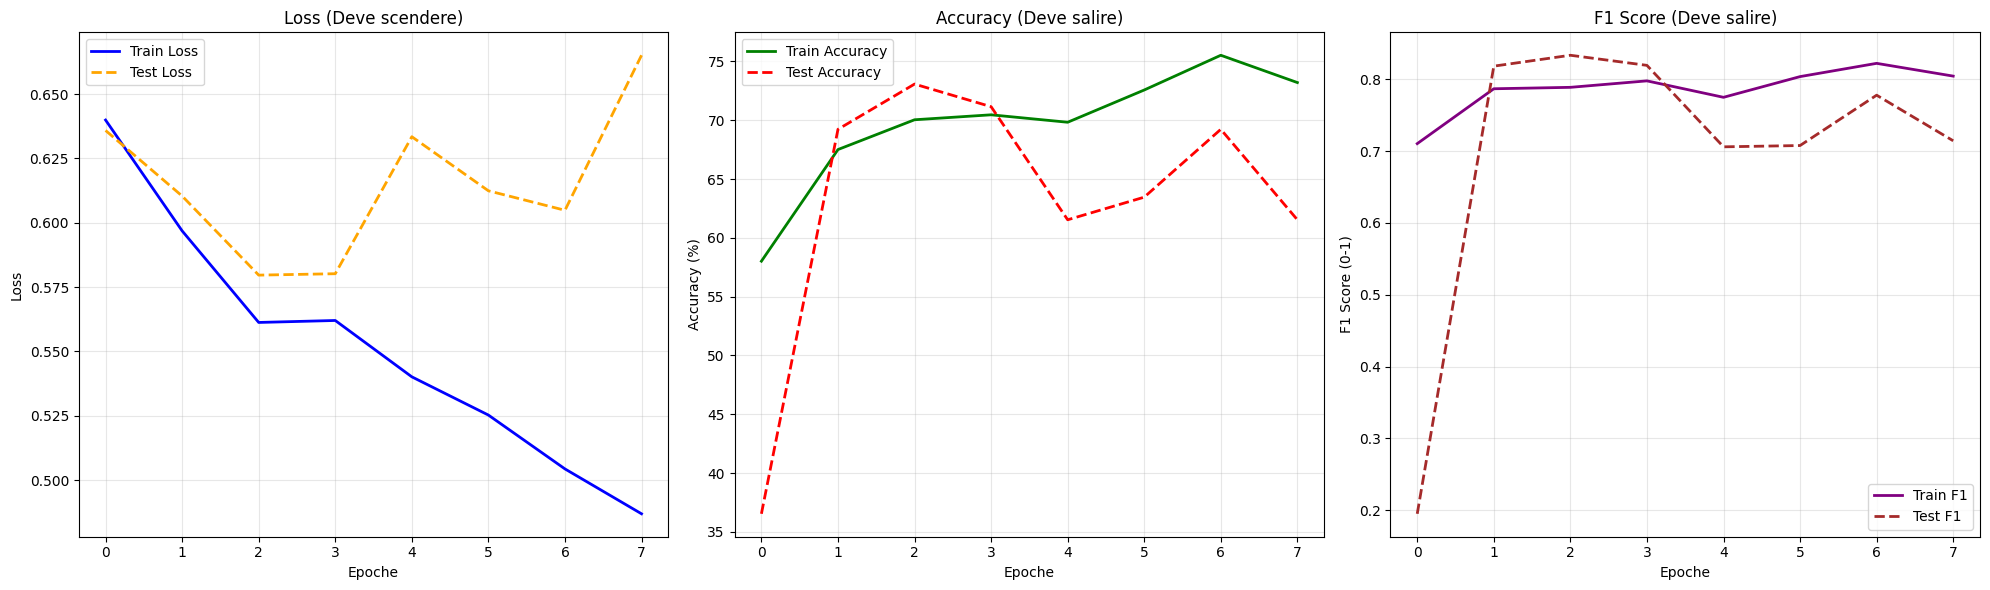

In [46]:
import matplotlib.pyplot as plt

# Grafici dell'ULTIMO FOLD
# Creiamo una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# --- Grafico 1: LOSS (Errore) ---
# Questo ci dice se il modello sta imparando (deve scendere)
axs[0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
axs[0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
axs[0].set_title('Loss (Deve scendere)')
axs[0].set_xlabel('Epoche')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# --- Grafico 2: ACCURACY ---
# Ci dice la percentuale totale di risposte corrette (deve salire)
axs[1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
axs[1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
axs[1].set_title('Accuracy (Deve salire)')
axs[1].set_xlabel('Epoche')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# --- Grafico 3: F1 SCORE ---
# Critico per dati sbilanciati o medici: media armonica tra precisione e recupero
axs[2].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
axs[2].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
axs[2].set_title('F1 Score (Deve salire)')
axs[2].set_xlabel('Epoche')
axs[2].set_ylabel('F1 Score (0-1)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout() # Aggiusta automaticamente gli spazi tra i grafici
plt.show()

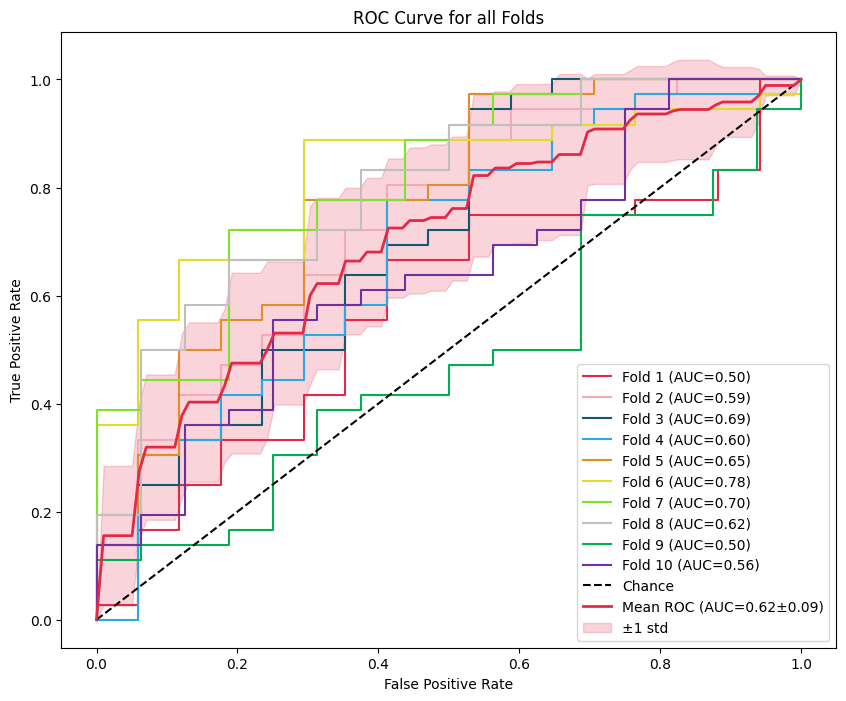

In [38]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()

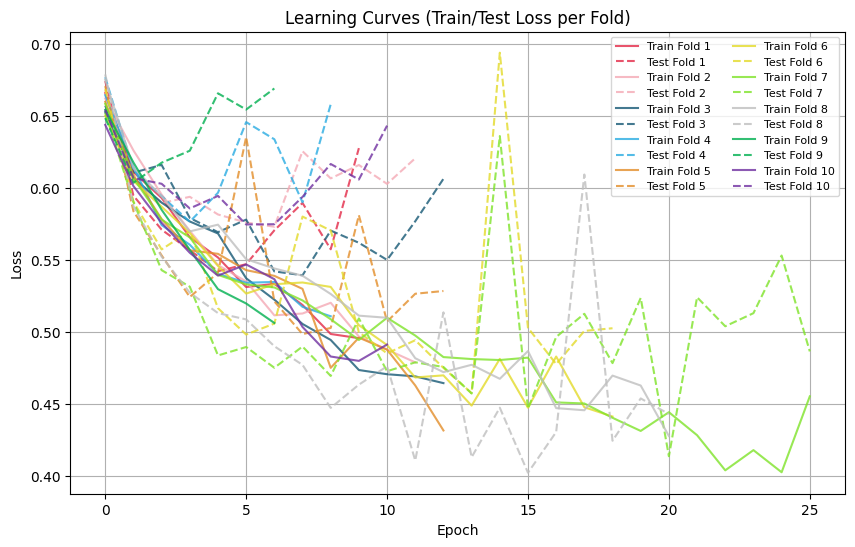

In [39]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))

for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===
      Accuracy  F1 Score  Sensitivity (Recall)  Specificity     AUC
mean    0.7491    0.8414                0.9667       0.2754  0.6210
std     0.0454    0.0216                0.0468       0.2181  0.0903
min     0.6792    0.8090                0.8611       0.0000  0.5000
max     0.8113    0.8750                1.0000       0.7059  0.7835


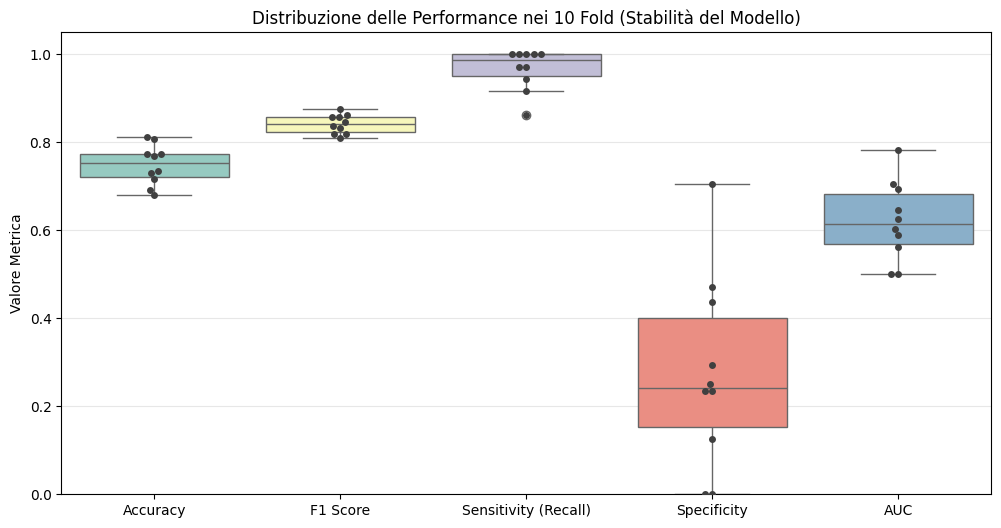

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Creazione di un DataFrame con tutti i risultati
results_data = {
    'Accuracy': np.array(accuracy_list_all_folds) / 100,  # <--- DIVISO PER 100
    'F1 Score': f1_list_all_folds,
    'Sensitivity (Recall)': sensitivity_list_all_folds,
    'Specificity': specificity_list_all_folds,
    'AUC': auc_score_list_all_folds
}

df_results = pd.DataFrame(results_data)

# 2. Calcolo delle Statistiche (Media e Deviazione Standard)
# La deviazione standard (std) ti dice quanto il modello è "instabile" tra un fold e l'altro
summary = df_results.describe().loc[['mean', 'std', 'min', 'max']]

print("=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===")
print(summary.round(4))

# 3. Visualizzazione Grafica (Boxplot)
# Questo grafico è fondamentale: la linea verde è la mediana, la scatola è dove cade il 50% dei casi.
# Se la scatola è molto "alta", il modello è instabile. Se è schiacciata, è molto robusto.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, palette="Set3")
sns.swarmplot(data=df_results, color=".25") # Aggiunge i punti reali per vedere la dispersione

plt.title('Distribuzione delle Performance nei 10 Fold (Stabilità del Modello)')
plt.ylabel('Valore Metrica')
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0, 1.05) # Fissa l'asse Y tra 0 e 1 (o poco più per l'accuracy se è in %)
# Se l'accuracy è in scala 0-100, commenta la riga sopra o adattala a (0, 105)

plt.show();

# Modello 2

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TwoStreamCNN(nn.Module):
    def __init__(self):
        super(TwoStreamCNN, self).__init__()

        # --- RAMO 1: Derivazioni Periferiche (Limb Leads: I, II, III, aVR, aVL, aVF) ---
        # Input: 6 canali
        self.branch1 = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # --- RAMO 2: Derivazioni Precordiali (Chest Leads: V1-V6) ---
        # Input: 6 canali
        self.branch2 = nn.Sequential(
            nn.Conv1d(6, 32, kernel_size=5, padding=2),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # --- BLOCCO DI FUSIONE ---
        # Concateniamo i risultati (64 canali + 64 canali = 128 canali)
        self.fusion_conv = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.MaxPool1d(2)
        )

        # Global Pooling per gestire qualsiasi lunghezza temporale
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classificatore Finale
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x shape: [Batch, 12, Length]

        # 1. Separiamo fisicamente i canali
        # I primi 6 canali vanno al Ramo 1
        input_limb = x[:, :6, :]
        # Gli ultimi 6 canali vanno al Ramo 2
        input_chest = x[:, 6:, :]

        # 2. Elaborazione Parallela
        out1 = self.branch1(input_limb)
        out2 = self.branch2(input_chest)

        # 3. Concatenazione lungo la dimensione dei canali (dim=1)
        # out1 e out2 devono avere la stessa lunghezza temporale (garantito dai MaxPool uguali)
        combined = torch.cat((out1, out2), dim=1)

        # 4. Fusione ed estrazione feature di alto livello
        features = self.fusion_conv(combined)

        # 5. Pooling e Classificazione
        features = self.global_pool(features).squeeze(-1)
        logits = self.classifier(features)

        return torch.sigmoid(logits)

In [48]:
#implementation of the ten fold cross-validation

strat_kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

f1_list_all_folds = []
f1_list_all_folds_train = []
sensitivity_list_all_folds = []
sensitivity_list_all_folds_train = []
specificity_list_all_folds = []
specificity_list_all_folds_train = []
accuracy_list_all_folds = []
accuracy_list_all_folds_train = []
auc_score_list_all_folds = []
auc_score_list_all_folds_train = []
fpr_list_all_folds = []
tpr_list_all_folds = []
test_loss_all_folds = []
train_loss_all_folds = []
epochs_all_fold = []
train_loss_max = []
test_loss_max = []

num_epocs = 50

for train_index, test_index in strat_kf.split(tabular_data, tabular_data['sport_ability']):
    X_train, X_test = tabular_data.iloc[train_index,:], tabular_data.iloc[test_index,:]
    ecg_train = signals[train_index,:,:]
    ecg_test = signals[test_index,:,:]

    ecg_train_segments, tabular_train_expand = segment_ecg(ecg_train, X_train)
    ecg_test_segments, tabular_test_expand = segment_ecg(ecg_test, X_test)

    Y_train = tabular_train_expand['sport_ability']
    Y_test = tabular_test_expand['sport_ability']

    X_train_final = tabular_train_expand.drop(columns=['sport_ability', 'ECG_patient_id'])
    X_test_final = tabular_test_expand.drop(columns=['sport_ability', 'ECG_patient_id'])

    X_train_final['age_at_exam'] = X_train_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_train_final['trainning_load'] = X_train_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    imputer = IterativeImputer()
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_final), columns=X_train_final.columns)

    categorical_cols = ['sex', 'sport_classification']
    numeric_cols = ['age_at_exam', 'height', 'weight', 'trainning_load']

    X_test_final['age_at_exam'] = X_test_final['age_at_exam'].apply(lambda x: x if 0.0 <= x <= 100.0 else np.nan)
    X_test_final['trainning_load'] = X_test_final['trainning_load'].apply(lambda x: x if 0 < x <= 4 else np.nan)

    X_test_imputed = pd.DataFrame(imputer.transform(X_test_final), columns=X_test_final.columns)

    scaler = StandardScaler()
    X_train_imputed[numeric_cols] = scaler.fit_transform(X_train_imputed[numeric_cols])
    X_test_imputed[numeric_cols] = scaler.transform(X_test_imputed[numeric_cols])

    for col in categorical_cols:
        X_train_imputed[col] = X_train_imputed[col].apply(lambda x: -1 if x == 0 else x)
        X_test_imputed[col] = X_test_imputed[col].apply(lambda x: -1 if x == 0 else x)

    train_final_df = pd.concat([X_train_imputed[numeric_cols], X_train_imputed[categorical_cols]], axis=1)
    test_final_df = pd.concat([X_test_imputed[numeric_cols], X_test_imputed[categorical_cols]], axis=1)

    train_dataset = ECGDataset(ecg_train_segments, Y_train)
    test_dataset = ECGDataset(ecg_test_segments, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = TwoStreamCNN().to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    ## Variabili early-stopping
    best_test_loss = float('inf')
    patience = 5
    trigger_times = 0

    f1_list_single_fold = []
    f1_list_single_fold_train = []
    sensitivity_list_single_fold = []
    sensitivity_list_single_fold_train = []
    specificity_list_single_fold = []
    specificity_list_single_fold_train = []
    accuracy_list_single_fold = []
    accuracy_list_single_fold_train = []
    auc_score_list_single_fold = []
    auc_score_list_single_fold_train = []
    fpr_list_single_fold = []
    tpr_list_single_fold = []
    train_loss_single_fold = []
    test_loss_single_fold = []
    epochs_single_fold = []

    for epoch in tqdm(range(num_epocs)):

        train_loss = 0
        correct = 0

        all_labels = []
        all_preds = []
        all_outputs = []

        for signals_ecg, labels in train_loader:
            model.train()
            # Rimosso tabular.to(device)
            signals_ecg, labels = signals_ecg.to(device), labels.to(device)

            optimizer.zero_grad()

            # Passiamo solo il segnale al modello
            outputs = model(signals_ecg)

            loss = criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            predicted = (outputs > 0.6).int()
            labels = labels.int()
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu())
            all_preds.extend(predicted.cpu())
            all_outputs.extend(outputs.cpu())

        print('\n')
        print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}")

        train_loss_single_fold.append(train_loss/len(train_loader))
        train_accuracy = accuracy_score(all_labels, all_preds) * 100
        f1 = f1_score(all_labels, all_preds)
        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        auc_score = roc_auc_score(all_labels, all_preds)

        f1_list_single_fold_train.append(f1)
        sensitivity_list_single_fold_train.append(sensitivity)
        specificity_list_single_fold_train.append(specificity)
        accuracy_list_single_fold_train.append(train_accuracy)
        auc_score_list_single_fold_train.append(auc_score)

        model.eval()

        all_labels = []
        all_preds = []
        all_outputs = []

        with torch.no_grad():

            correct = 0
            test_loss = 0

            for signals_ecg, labels in test_loader:
                # Rimosso tabular.to(device)
                signals_ecg, labels = signals_ecg.to(device), labels.to(device)

                # Passiamo solo il segnale
                outputs = model(signals_ecg)

                loss = criterion(outputs.squeeze(), labels.squeeze())
                test_loss += loss.item()
                predicted = (outputs.squeeze() > 0.6).int()
                labels = labels.squeeze().int()
                correct += (predicted.squeeze() == labels).sum().item()
                all_labels.extend(labels.cpu())
                all_preds.extend(predicted.cpu())
                all_outputs.extend(outputs.squeeze().cpu())

            test_loss /= len(test_loader)

            test_loss_single_fold.append(test_loss)
            test_accuracy = accuracy_score(all_labels, all_preds) * 100
            f1 = f1_score(all_labels, all_preds)
            tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
            sensitivity = tp / (tp + fn)
            specificity = tn / (tn + fp)
            auc_score = roc_auc_score(all_labels, all_preds)

            f1_list_single_fold.append(f1)
            sensitivity_list_single_fold.append(sensitivity)
            specificity_list_single_fold.append(specificity)
            accuracy_list_single_fold.append(test_accuracy)
            auc_score_list_single_fold.append(auc_score)
            fpr, tpr, _ = roc_curve(all_labels, all_outputs)
            fpr_list_single_fold.append(fpr)
            tpr_list_single_fold.append(tpr)
            epochs_single_fold.append(epoch)

            print(f"Test loss: {test_loss}, Accuracy: {test_accuracy:.2f}%", f"F1 Score: {f1:.4f}, Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}, AUC: {auc_score:.4f}")
            print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

            ## early stopping
            if test_loss < best_test_loss:
                 best_test_loss = test_loss
                 trigger_times = 0
                 # Salviamo i pesi del modello attuale perché è il migliore finora
                 torch.save(model.state_dict(), 'best_model_fold.pth')
            else:
                 trigger_times += 1
                 # print(f"Patience: {trigger_times}/{patience}") # Decommenta se vuoi vedere il contatore

                 if trigger_times >= patience:
                     print(f"Early stopping attivato all'epoca {epoch+1}!")
                     # IMPORTANTE: Prima di uscire, ricarichiamo i pesi migliori salvati
                     # Altrimenti il modello rimarrebbe quello "peggiorato" dell'ultima epoca
                     model.load_state_dict(torch.load('best_model_fold.pth'))
                     break # Esce dal ciclo "for epoch" e passa al prossimo Fold

    max_f1 = max(f1_list_single_fold)
    max_f1_index = f1_list_single_fold.index(max_f1)

    f1_list_all_folds.append(f1_list_single_fold[max_f1_index])
    f1_list_all_folds_train.append(f1_list_single_fold_train[max_f1_index])
    sensitivity_list_all_folds.append(sensitivity_list_single_fold[max_f1_index])
    sensitivity_list_all_folds_train.append(sensitivity_list_single_fold_train[max_f1_index])
    specificity_list_all_folds.append(specificity_list_single_fold[max_f1_index])
    specificity_list_all_folds_train.append(specificity_list_single_fold_train[max_f1_index])
    accuracy_list_all_folds.append(accuracy_list_single_fold[max_f1_index])
    accuracy_list_all_folds_train.append(accuracy_list_single_fold_train[max_f1_index])
    auc_score_list_all_folds.append(auc_score_list_single_fold[max_f1_index])
    auc_score_list_all_folds_train.append(auc_score_list_single_fold_train[max_f1_index])
    fpr_list_all_folds.append(fpr_list_single_fold[max_f1_index])
    tpr_list_all_folds.append(tpr_list_single_fold[max_f1_index])
    test_loss_all_folds.append(test_loss_single_fold)
    test_loss_max.append(test_loss_single_fold[max_f1_index])
    train_loss_all_folds.append(train_loss_single_fold)
    train_loss_max.append(train_loss_single_fold[max_f1_index])
    epochs_all_fold.append(epochs_single_fold[max_f1_index])

  2%|▏         | 1/50 [00:00<00:21,  2.26it/s]



Epoch 1, Train Loss: 0.6379684885342916
Test loss: 0.615900456905365, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:19,  2.40it/s]



Epoch 2, Train Loss: 0.5944778621196747
Test loss: 0.5898166596889496, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:19,  2.44it/s]



Epoch 3, Train Loss: 0.5632156829039255
Test loss: 0.5720518231391907, Accuracy: 66.04% F1 Score: 0.7907, Sensitivity: 0.9444, Specificity: 0.0588, AUC: 0.5016
TP: 34, FP: 16, TN: 1, FN: 2


  8%|▊         | 4/50 [00:01<00:18,  2.52it/s]



Epoch 4, Train Loss: 0.558689828713735
Test loss: 0.5727305561304092, Accuracy: 66.04% F1 Score: 0.7805, Sensitivity: 0.8889, Specificity: 0.1765, AUC: 0.5327
TP: 32, FP: 14, TN: 3, FN: 4


 10%|█         | 5/50 [00:02<00:17,  2.51it/s]



Epoch 5, Train Loss: 0.5446203311284383
Test loss: 0.5491872876882553, Accuracy: 62.26% F1 Score: 0.7500, Sensitivity: 0.8333, Specificity: 0.1765, AUC: 0.5049
TP: 30, FP: 14, TN: 3, FN: 6


 12%|█▏        | 6/50 [00:02<00:17,  2.53it/s]



Epoch 6, Train Loss: 0.5285433650016784
Test loss: 0.5569576770067215, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9


 14%|█▍        | 7/50 [00:02<00:17,  2.53it/s]



Epoch 7, Train Loss: 0.5119275490442912
Test loss: 0.5621608048677444, Accuracy: 62.26% F1 Score: 0.7561, Sensitivity: 0.8611, Specificity: 0.1176, AUC: 0.4894
TP: 31, FP: 15, TN: 2, FN: 5


 16%|█▌        | 8/50 [00:03<00:16,  2.54it/s]



Epoch 8, Train Loss: 0.5152735650539398
Test loss: 0.5646913051605225, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11


 18%|█▊        | 9/50 [00:03<00:15,  2.61it/s]



Epoch 9, Train Loss: 0.5125527083873749
Test loss: 0.5501332432031631, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9


 18%|█▊        | 9/50 [00:03<00:18,  2.27it/s]



Epoch 10, Train Loss: 0.5064530769983927
Test loss: 0.5651052296161652, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11
Early stopping attivato all'epoca 10!



  0%|          | 0/50 [00:00<?, ?it/s]



Epoch 1, Train Loss: 0.644137316942215


  2%|▏         | 1/50 [00:00<00:28,  1.71it/s]

Test loss: 0.6303077638149261, Accuracy: 32.08% F1 Score: 0.0000, Sensitivity: 0.0000, Specificity: 1.0000, AUC: 0.5000
TP: 0, FP: 0, TN: 17, FN: 36


Epoch 2, Train Loss: 0.6045666197935741


  4%|▍         | 2/50 [00:01<00:28,  1.69it/s]

Test loss: 0.6066408753395081, Accuracy: 71.70% F1 Score: 0.8235, Sensitivity: 0.9722, Specificity: 0.1765, AUC: 0.5743
TP: 35, FP: 14, TN: 3, FN: 1


  6%|▌         | 3/50 [00:01<00:25,  1.82it/s]



Epoch 3, Train Loss: 0.57832573056221
Test loss: 0.5744726210832596, Accuracy: 81.13% F1 Score: 0.8684, Sensitivity: 0.9167, Specificity: 0.5882, AUC: 0.7525
TP: 33, FP: 7, TN: 10, FN: 3


  8%|▊         | 4/50 [00:02<00:26,  1.74it/s]



Epoch 4, Train Loss: 0.561067529519399
Test loss: 0.5836076736450195, Accuracy: 58.49% F1 Score: 0.6207, Sensitivity: 0.5000, Specificity: 0.7647, AUC: 0.6324
TP: 18, FP: 4, TN: 13, FN: 18


 10%|█         | 5/50 [00:02<00:25,  1.80it/s]



Epoch 5, Train Loss: 0.5431265076001485
Test loss: 0.5782840251922607, Accuracy: 71.70% F1 Score: 0.7692, Sensitivity: 0.6944, Specificity: 0.7647, AUC: 0.7296
TP: 25, FP: 4, TN: 13, FN: 11


Epoch 6, Train Loss: 0.5285734991232555


 12%|█▏        | 6/50 [00:03<00:24,  1.78it/s]

Test loss: 0.5737541317939758, Accuracy: 62.26% F1 Score: 0.6429, Sensitivity: 0.5000, Specificity: 0.8824, AUC: 0.6912
TP: 18, FP: 2, TN: 15, FN: 18


 14%|█▍        | 7/50 [00:03<00:21,  2.00it/s]



Epoch 7, Train Loss: 0.5286667088667552
Test loss: 0.5991916656494141, Accuracy: 58.49% F1 Score: 0.6207, Sensitivity: 0.5000, Specificity: 0.7647, AUC: 0.6324
TP: 18, FP: 4, TN: 13, FN: 18


 16%|█▌        | 8/50 [00:04<00:19,  2.17it/s]



Epoch 8, Train Loss: 0.5216716607411702
Test loss: 0.5601962208747864, Accuracy: 66.04% F1 Score: 0.7353, Sensitivity: 0.6944, Specificity: 0.5882, AUC: 0.6413
TP: 25, FP: 7, TN: 10, FN: 11


 18%|█▊        | 9/50 [00:04<00:17,  2.31it/s]



Epoch 9, Train Loss: 0.5042181034882863
Test loss: 0.5996894836425781, Accuracy: 69.81% F1 Score: 0.7647, Sensitivity: 0.7222, Specificity: 0.6471, AUC: 0.6846
TP: 26, FP: 6, TN: 11, FN: 10


 20%|██        | 10/50 [00:04<00:16,  2.42it/s]



Epoch 10, Train Loss: 0.5147294580936432
Test loss: 0.5994210243225098, Accuracy: 62.26% F1 Score: 0.6429, Sensitivity: 0.5000, Specificity: 0.8824, AUC: 0.6912
TP: 18, FP: 2, TN: 15, FN: 18


 22%|██▏       | 11/50 [00:05<00:15,  2.47it/s]



Epoch 11, Train Loss: 0.5182095170021057
Test loss: 0.5356466621160507, Accuracy: 75.47% F1 Score: 0.8116, Sensitivity: 0.7778, Specificity: 0.7059, AUC: 0.7418
TP: 28, FP: 5, TN: 12, FN: 8


 24%|██▍       | 12/50 [00:05<00:15,  2.49it/s]



Epoch 12, Train Loss: 0.5007346868515015
Test loss: 0.5315890312194824, Accuracy: 66.04% F1 Score: 0.7273, Sensitivity: 0.6667, Specificity: 0.6471, AUC: 0.6569
TP: 24, FP: 6, TN: 11, FN: 12


 26%|██▌       | 13/50 [00:06<00:14,  2.51it/s]



Epoch 13, Train Loss: 0.48792086640993754
Test loss: 0.5549212694168091, Accuracy: 71.70% F1 Score: 0.7692, Sensitivity: 0.6944, Specificity: 0.7647, AUC: 0.7296
TP: 25, FP: 4, TN: 13, FN: 11


 28%|██▊       | 14/50 [00:06<00:14,  2.54it/s]



Epoch 14, Train Loss: 0.5098935981591542
Test loss: 0.5048401206731796, Accuracy: 79.25% F1 Score: 0.8493, Sensitivity: 0.8611, Specificity: 0.6471, AUC: 0.7541
TP: 31, FP: 6, TN: 11, FN: 5


 30%|███       | 15/50 [00:06<00:12,  2.75it/s]



Epoch 15, Train Loss: 0.4973837733268738
Test loss: 0.6214539408683777, Accuracy: 54.72% F1 Score: 0.5385, Sensitivity: 0.3889, Specificity: 0.8824, AUC: 0.6356
TP: 14, FP: 2, TN: 15, FN: 22


 32%|███▏      | 16/50 [00:07<00:11,  2.92it/s]



Epoch 16, Train Loss: 0.46454373200734456
Test loss: 0.5479640066623688, Accuracy: 73.58% F1 Score: 0.7879, Sensitivity: 0.7222, Specificity: 0.7647, AUC: 0.7435
TP: 26, FP: 4, TN: 13, FN: 10


 34%|███▍      | 17/50 [00:07<00:10,  3.05it/s]



Epoch 17, Train Loss: 0.45333461960156757
Test loss: 0.6569222509860992, Accuracy: 52.83% F1 Score: 0.4898, Sensitivity: 0.3333, Specificity: 0.9412, AUC: 0.6373
TP: 12, FP: 1, TN: 16, FN: 24


 36%|███▌      | 18/50 [00:07<00:10,  3.13it/s]



Epoch 18, Train Loss: 0.46041975418726605
Test loss: 0.5355005264282227, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10


 36%|███▌      | 18/50 [00:07<00:14,  2.27it/s]



Epoch 19, Train Loss: 0.4834814965724945
Test loss: 0.5714235156774521, Accuracy: 66.04% F1 Score: 0.7097, Sensitivity: 0.6111, Specificity: 0.7647, AUC: 0.6879
TP: 22, FP: 4, TN: 13, FN: 14
Early stopping attivato all'epoca 19!



  2%|▏         | 1/50 [00:00<00:15,  3.24it/s]



Epoch 1, Train Loss: 0.6362505197525025
Test loss: 0.6338110566139221, Accuracy: 52.83% F1 Score: 0.6154, Sensitivity: 0.5556, Specificity: 0.4706, AUC: 0.5131
TP: 20, FP: 9, TN: 8, FN: 16


  4%|▍         | 2/50 [00:00<00:14,  3.23it/s]



Epoch 2, Train Loss: 0.604746158917745
Test loss: 0.6077935993671417, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.23it/s]



Epoch 3, Train Loss: 0.5776424328486125
Test loss: 0.587294340133667, Accuracy: 75.47% F1 Score: 0.8471, Sensitivity: 1.0000, Specificity: 0.2353, AUC: 0.6176
TP: 36, FP: 13, TN: 4, FN: 0


  8%|▊         | 4/50 [00:01<00:14,  3.22it/s]



Epoch 4, Train Loss: 0.5531023343404134
Test loss: 0.5867048650979996, Accuracy: 60.38% F1 Score: 0.7123, Sensitivity: 0.7222, Specificity: 0.3529, AUC: 0.5376
TP: 26, FP: 11, TN: 6, FN: 10


 10%|█         | 5/50 [00:01<00:14,  3.16it/s]



Epoch 5, Train Loss: 0.5445883631706238
Test loss: 0.5529451370239258, Accuracy: 67.92% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5294, AUC: 0.6397
TP: 27, FP: 8, TN: 9, FN: 9


 12%|█▏        | 6/50 [00:01<00:13,  3.22it/s]



Epoch 6, Train Loss: 0.5465948124726613
Test loss: 0.6178812086582184, Accuracy: 66.04% F1 Score: 0.7805, Sensitivity: 0.8889, Specificity: 0.1765, AUC: 0.5327
TP: 32, FP: 14, TN: 3, FN: 4


 14%|█▍        | 7/50 [00:02<00:13,  3.15it/s]



Epoch 7, Train Loss: 0.5294538040955862
Test loss: 0.5545800179243088, Accuracy: 67.92% F1 Score: 0.7606, Sensitivity: 0.7500, Specificity: 0.5294, AUC: 0.6397
TP: 27, FP: 8, TN: 9, FN: 9


 16%|█▌        | 8/50 [00:02<00:13,  3.22it/s]



Epoch 8, Train Loss: 0.5171526312828064
Test loss: 0.5837759375572205, Accuracy: 64.15% F1 Score: 0.7397, Sensitivity: 0.7500, Specificity: 0.4118, AUC: 0.5809
TP: 27, FP: 10, TN: 7, FN: 9


 18%|█▊        | 9/50 [00:02<00:12,  3.22it/s]



Epoch 9, Train Loss: 0.497562042872111
Test loss: 0.5175841003656387, Accuracy: 71.70% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5882, AUC: 0.6830
TP: 28, FP: 7, TN: 10, FN: 8


 20%|██        | 10/50 [00:03<00:12,  3.26it/s]



Epoch 10, Train Loss: 0.4889446993668874
Test loss: 0.5553564131259918, Accuracy: 62.26% F1 Score: 0.7059, Sensitivity: 0.6667, Specificity: 0.5294, AUC: 0.5980
TP: 24, FP: 8, TN: 9, FN: 12


 22%|██▏       | 11/50 [00:03<00:11,  3.28it/s]



Epoch 11, Train Loss: 0.4840334494908651
Test loss: 0.5948318243026733, Accuracy: 60.38% F1 Score: 0.6557, Sensitivity: 0.5556, Specificity: 0.7059, AUC: 0.6307
TP: 20, FP: 5, TN: 12, FN: 16


 24%|██▍       | 12/50 [00:03<00:11,  3.31it/s]



Epoch 12, Train Loss: 0.4731775383154551
Test loss: 0.567575603723526, Accuracy: 60.38% F1 Score: 0.6667, Sensitivity: 0.5833, Specificity: 0.6471, AUC: 0.6152
TP: 21, FP: 6, TN: 11, FN: 15


 26%|██▌       | 13/50 [00:03<00:11,  3.33it/s]



Epoch 13, Train Loss: 0.46812116901079814
Test loss: 0.5452971458435059, Accuracy: 62.26% F1 Score: 0.7222, Sensitivity: 0.7222, Specificity: 0.4118, AUC: 0.5670
TP: 26, FP: 10, TN: 7, FN: 10


 26%|██▌       | 13/50 [00:04<00:12,  3.00it/s]



Epoch 14, Train Loss: 0.4469133377075195
Test loss: 0.5415745824575424, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10
Early stopping attivato all'epoca 14!



  2%|▏         | 1/50 [00:00<00:16,  2.89it/s]



Epoch 1, Train Loss: 0.640489931901296
Test loss: 0.6314036846160889, Accuracy: 71.70% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.1176, AUC: 0.5588
TP: 36, FP: 15, TN: 2, FN: 0


  4%|▍         | 2/50 [00:00<00:17,  2.73it/s]



Epoch 2, Train Loss: 0.6008289754390717
Test loss: 0.6068128347396851, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:17,  2.72it/s]



Epoch 3, Train Loss: 0.5788597106933594
Test loss: 0.5746684521436691, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


  8%|▊         | 4/50 [00:01<00:16,  2.72it/s]



Epoch 4, Train Loss: 0.550884352127711
Test loss: 0.573711946606636, Accuracy: 71.70% F1 Score: 0.8101, Sensitivity: 0.8889, Specificity: 0.3529, AUC: 0.6209
TP: 32, FP: 11, TN: 6, FN: 4


 10%|█         | 5/50 [00:01<00:16,  2.75it/s]



Epoch 5, Train Loss: 0.525256731112798
Test loss: 0.5963588654994965, Accuracy: 77.36% F1 Score: 0.8500, Sensitivity: 0.9444, Specificity: 0.4118, AUC: 0.6781
TP: 34, FP: 10, TN: 7, FN: 2


 12%|█▏        | 6/50 [00:02<00:15,  2.79it/s]



Epoch 6, Train Loss: 0.5324665784835816
Test loss: 0.5997360646724701, Accuracy: 60.38% F1 Score: 0.6316, Sensitivity: 0.5000, Specificity: 0.8235, AUC: 0.6618
TP: 18, FP: 3, TN: 14, FN: 18


 14%|█▍        | 7/50 [00:02<00:15,  2.75it/s]



Epoch 7, Train Loss: 0.5551101823647817
Test loss: 0.572856068611145, Accuracy: 69.81% F1 Score: 0.8000, Sensitivity: 0.8889, Specificity: 0.2941, AUC: 0.5915
TP: 32, FP: 12, TN: 5, FN: 4


 16%|█▌        | 8/50 [00:02<00:15,  2.71it/s]



Epoch 8, Train Loss: 0.5264822542667389
Test loss: 0.5379309505224228, Accuracy: 73.58% F1 Score: 0.8056, Sensitivity: 0.8056, Specificity: 0.5882, AUC: 0.6969
TP: 29, FP: 7, TN: 10, FN: 7


 18%|█▊        | 9/50 [00:03<00:15,  2.71it/s]



Epoch 9, Train Loss: 0.48636245528856914
Test loss: 0.573506772518158, Accuracy: 75.47% F1 Score: 0.8060, Sensitivity: 0.7500, Specificity: 0.7647, AUC: 0.7574
TP: 27, FP: 4, TN: 13, FN: 9


 20%|██        | 10/50 [00:03<00:14,  2.85it/s]



Epoch 10, Train Loss: 0.4934178610642751
Test loss: 0.5555250495672226, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10


 22%|██▏       | 11/50 [00:03<00:13,  2.98it/s]



Epoch 11, Train Loss: 0.48747351169586184
Test loss: 0.5886376053094864, Accuracy: 69.81% F1 Score: 0.7500, Sensitivity: 0.6667, Specificity: 0.7647, AUC: 0.7157
TP: 24, FP: 4, TN: 13, FN: 12


 24%|██▍       | 12/50 [00:04<00:12,  3.06it/s]



Epoch 12, Train Loss: 0.48431954185167947
Test loss: 0.5339980572462082, Accuracy: 73.58% F1 Score: 0.8056, Sensitivity: 0.8056, Specificity: 0.5882, AUC: 0.6969
TP: 29, FP: 7, TN: 10, FN: 7


 26%|██▌       | 13/50 [00:04<00:11,  3.14it/s]



Epoch 13, Train Loss: 0.4728832264741262
Test loss: 0.5815367549657822, Accuracy: 67.92% F1 Score: 0.7952, Sensitivity: 0.9167, Specificity: 0.1765, AUC: 0.5466
TP: 33, FP: 14, TN: 3, FN: 3


 28%|██▊       | 14/50 [00:04<00:11,  3.17it/s]



Epoch 14, Train Loss: 0.480173397064209
Test loss: 0.5754581391811371, Accuracy: 75.47% F1 Score: 0.8169, Sensitivity: 0.8056, Specificity: 0.6471, AUC: 0.7263
TP: 29, FP: 6, TN: 11, FN: 7


 30%|███       | 15/50 [00:05<00:10,  3.23it/s]



Epoch 15, Train Loss: 0.4766402463118235
Test loss: 0.543138399720192, Accuracy: 69.81% F1 Score: 0.7778, Sensitivity: 0.7778, Specificity: 0.5294, AUC: 0.6536
TP: 28, FP: 8, TN: 9, FN: 8


 32%|███▏      | 16/50 [00:05<00:10,  3.27it/s]



Epoch 16, Train Loss: 0.4637112061182658
Test loss: 0.60356205701828, Accuracy: 71.70% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5882, AUC: 0.6830
TP: 28, FP: 7, TN: 10, FN: 8


 32%|███▏      | 16/50 [00:05<00:12,  2.80it/s]



Epoch 17, Train Loss: 0.45314146876335143
Test loss: 0.574118971824646, Accuracy: 71.70% F1 Score: 0.8148, Sensitivity: 0.9167, Specificity: 0.2941, AUC: 0.6054
TP: 33, FP: 12, TN: 5, FN: 3
Early stopping attivato all'epoca 17!



  2%|▏         | 1/50 [00:00<00:15,  3.22it/s]



Epoch 1, Train Loss: 0.6401414990425109
Test loss: 0.6232361495494843, Accuracy: 67.92% F1 Score: 0.8000, Sensitivity: 0.9444, Specificity: 0.1176, AUC: 0.5310
TP: 34, FP: 15, TN: 2, FN: 2


  4%|▍         | 2/50 [00:00<00:14,  3.22it/s]



Epoch 2, Train Loss: 0.6097428321838378
Test loss: 0.5859485119581223, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.19it/s]



Epoch 3, Train Loss: 0.5789888679981232
Test loss: 0.5440058410167694, Accuracy: 69.81% F1 Score: 0.8140, Sensitivity: 0.9722, Specificity: 0.1176, AUC: 0.5449
TP: 35, FP: 15, TN: 2, FN: 1


  8%|▊         | 4/50 [00:01<00:14,  3.20it/s]



Epoch 4, Train Loss: 0.5578986028830211
Test loss: 0.5031542181968689, Accuracy: 69.81% F1 Score: 0.7838, Sensitivity: 0.8056, Specificity: 0.4706, AUC: 0.6381
TP: 29, FP: 9, TN: 8, FN: 7


 10%|█         | 5/50 [00:01<00:14,  3.13it/s]



Epoch 5, Train Loss: 0.5592124501864115
Test loss: 0.4897456616163254, Accuracy: 73.58% F1 Score: 0.8293, Sensitivity: 0.9444, Specificity: 0.2941, AUC: 0.6193
TP: 34, FP: 12, TN: 5, FN: 2


 12%|█▏        | 6/50 [00:01<00:14,  3.10it/s]



Epoch 6, Train Loss: 0.5208853224913279
Test loss: 0.48436439037323, Accuracy: 71.70% F1 Score: 0.7826, Sensitivity: 0.7500, Specificity: 0.6471, AUC: 0.6985
TP: 27, FP: 6, TN: 11, FN: 9


 14%|█▍        | 7/50 [00:02<00:13,  3.17it/s]



Epoch 7, Train Loss: 0.5188049415747324
Test loss: 0.5512841492891312, Accuracy: 64.15% F1 Score: 0.6984, Sensitivity: 0.6111, Specificity: 0.7059, AUC: 0.6585
TP: 22, FP: 5, TN: 12, FN: 14


 16%|█▌        | 8/50 [00:02<00:13,  3.22it/s]



Epoch 8, Train Loss: 0.5006593386332194
Test loss: 0.5336477607488632, Accuracy: 67.92% F1 Score: 0.7213, Sensitivity: 0.6111, Specificity: 0.8235, AUC: 0.7173
TP: 22, FP: 3, TN: 14, FN: 14


 18%|█▊        | 9/50 [00:02<00:12,  3.22it/s]



Epoch 9, Train Loss: 0.4792928298314412
Test loss: 0.4976970702409744, Accuracy: 75.47% F1 Score: 0.8395, Sensitivity: 0.9444, Specificity: 0.3529, AUC: 0.6487
TP: 34, FP: 11, TN: 6, FN: 2


 20%|██        | 10/50 [00:03<00:12,  3.26it/s]



Epoch 10, Train Loss: 0.5153601010640462
Test loss: 0.5298794806003571, Accuracy: 71.70% F1 Score: 0.8052, Sensitivity: 0.8611, Specificity: 0.4118, AUC: 0.6364
TP: 31, FP: 10, TN: 7, FN: 5


 20%|██        | 10/50 [00:03<00:13,  2.92it/s]



Epoch 11, Train Loss: 0.4678813934326172
Test loss: 0.5355474501848221, Accuracy: 64.15% F1 Score: 0.7246, Sensitivity: 0.6944, Specificity: 0.5294, AUC: 0.6119
TP: 25, FP: 8, TN: 9, FN: 11
Early stopping attivato all'epoca 11!



  2%|▏         | 1/50 [00:00<00:15,  3.24it/s]



Epoch 1, Train Loss: 0.6523346821467082
Test loss: 0.6327484250068665, Accuracy: 33.96% F1 Score: 0.0541, Sensitivity: 0.0278, Specificity: 1.0000, AUC: 0.5139
TP: 1, FP: 0, TN: 17, FN: 35


  4%|▍         | 2/50 [00:00<00:14,  3.22it/s]



Epoch 2, Train Loss: 0.603628381093343
Test loss: 0.5962406396865845, Accuracy: 67.92% F1 Score: 0.8090, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 17, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.20it/s]



Epoch 3, Train Loss: 0.5838492830594381
Test loss: 0.5707433074712753, Accuracy: 69.81% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0588, AUC: 0.5294
TP: 36, FP: 16, TN: 1, FN: 0


  8%|▊         | 4/50 [00:01<00:14,  3.20it/s]



Epoch 4, Train Loss: 0.5615959167480469
Test loss: 0.5621457993984222, Accuracy: 64.15% F1 Score: 0.6984, Sensitivity: 0.6111, Specificity: 0.7059, AUC: 0.6585
TP: 22, FP: 5, TN: 12, FN: 14


 10%|█         | 5/50 [00:01<00:13,  3.26it/s]



Epoch 5, Train Loss: 0.5541156888008117
Test loss: 0.5765862315893173, Accuracy: 66.04% F1 Score: 0.7857, Sensitivity: 0.9167, Specificity: 0.1176, AUC: 0.5172
TP: 33, FP: 15, TN: 2, FN: 3


 12%|█▏        | 6/50 [00:01<00:13,  3.25it/s]



Epoch 6, Train Loss: 0.542387968301773
Test loss: 0.5284519791603088, Accuracy: 66.04% F1 Score: 0.7097, Sensitivity: 0.6111, Specificity: 0.7647, AUC: 0.6879
TP: 22, FP: 4, TN: 13, FN: 14


 14%|█▍        | 7/50 [00:02<00:13,  3.23it/s]



Epoch 7, Train Loss: 0.5296209593613942
Test loss: 0.5212040990591049, Accuracy: 77.36% F1 Score: 0.8333, Sensitivity: 0.8333, Specificity: 0.6471, AUC: 0.7402
TP: 30, FP: 6, TN: 11, FN: 6


 16%|█▌        | 8/50 [00:02<00:12,  3.26it/s]



Epoch 8, Train Loss: 0.5199645737806956
Test loss: 0.522342175245285, Accuracy: 69.81% F1 Score: 0.8000, Sensitivity: 0.8889, Specificity: 0.2941, AUC: 0.5915
TP: 32, FP: 12, TN: 5, FN: 4


 18%|█▊        | 9/50 [00:02<00:12,  3.25it/s]



Epoch 9, Train Loss: 0.5043843487898508
Test loss: 0.504108652472496, Accuracy: 75.47% F1 Score: 0.8267, Sensitivity: 0.8611, Specificity: 0.5294, AUC: 0.6953
TP: 31, FP: 8, TN: 9, FN: 5


 20%|██        | 10/50 [00:03<00:12,  3.25it/s]



Epoch 10, Train Loss: 0.49313777685165405
Test loss: 0.597732275724411, Accuracy: 64.15% F1 Score: 0.6780, Sensitivity: 0.5556, Specificity: 0.8235, AUC: 0.6895
TP: 20, FP: 3, TN: 14, FN: 16


 22%|██▏       | 11/50 [00:03<00:11,  3.28it/s]



Epoch 11, Train Loss: 0.5046810309092203
Test loss: 0.5390261262655258, Accuracy: 71.70% F1 Score: 0.7761, Sensitivity: 0.7222, Specificity: 0.7059, AUC: 0.7141
TP: 26, FP: 5, TN: 12, FN: 10


 24%|██▍       | 12/50 [00:03<00:12,  3.14it/s]



Epoch 12, Train Loss: 0.4845654328664144
Test loss: 0.5053554177284241, Accuracy: 66.04% F1 Score: 0.7692, Sensitivity: 0.8333, Specificity: 0.2941, AUC: 0.5637
TP: 30, FP: 12, TN: 5, FN: 6


 26%|██▌       | 13/50 [00:04<00:12,  2.99it/s]



Epoch 13, Train Loss: 0.47716183265050255
Test loss: 0.4836793690919876, Accuracy: 67.92% F1 Score: 0.7671, Sensitivity: 0.7778, Specificity: 0.4706, AUC: 0.6242
TP: 28, FP: 9, TN: 8, FN: 8


 28%|██▊       | 14/50 [00:04<00:12,  2.92it/s]



Epoch 14, Train Loss: 0.47018444339434307
Test loss: 0.5589962899684906, Accuracy: 67.92% F1 Score: 0.7733, Sensitivity: 0.8056, Specificity: 0.4118, AUC: 0.6087
TP: 29, FP: 10, TN: 7, FN: 7


 30%|███       | 15/50 [00:04<00:12,  2.88it/s]



Epoch 15, Train Loss: 0.47225128213564554
Test loss: 0.6246154010295868, Accuracy: 56.60% F1 Score: 0.5818, Sensitivity: 0.4444, Specificity: 0.8235, AUC: 0.6340
TP: 16, FP: 3, TN: 14, FN: 20


 32%|███▏      | 16/50 [00:05<00:12,  2.82it/s]



Epoch 16, Train Loss: 0.4455276906490326
Test loss: 0.611965149641037, Accuracy: 69.81% F1 Score: 0.7895, Sensitivity: 0.8333, Specificity: 0.4118, AUC: 0.6225
TP: 30, FP: 10, TN: 7, FN: 6


 34%|███▍      | 17/50 [00:05<00:11,  2.82it/s]



Epoch 17, Train Loss: 0.46206203699111936
Test loss: 0.5193003863096237, Accuracy: 75.47% F1 Score: 0.8354, Sensitivity: 0.9167, Specificity: 0.4118, AUC: 0.6642
TP: 33, FP: 10, TN: 7, FN: 3


 34%|███▍      | 17/50 [00:05<00:11,  2.87it/s]



Epoch 18, Train Loss: 0.4456968029340108
Test loss: 0.5857262909412384, Accuracy: 58.49% F1 Score: 0.6562, Sensitivity: 0.5833, Specificity: 0.5882, AUC: 0.5858
TP: 21, FP: 7, TN: 10, FN: 15
Early stopping attivato all'epoca 18!



  2%|▏         | 1/50 [00:00<00:15,  3.09it/s]



Epoch 1, Train Loss: 0.6430854876836141
Test loss: 0.6232447326183319, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:15,  3.18it/s]



Epoch 2, Train Loss: 0.5987202227115631
Test loss: 0.5936723351478577, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.18it/s]



Epoch 3, Train Loss: 0.5743740200996399
Test loss: 0.5478860139846802, Accuracy: 71.15% F1 Score: 0.8235, Sensitivity: 0.9722, Specificity: 0.1250, AUC: 0.5486
TP: 35, FP: 14, TN: 2, FN: 1


  8%|▊         | 4/50 [00:01<00:14,  3.20it/s]



Epoch 4, Train Loss: 0.5630158762137095
Test loss: 0.5238045156002045, Accuracy: 69.23% F1 Score: 0.7838, Sensitivity: 0.8056, Specificity: 0.4375, AUC: 0.6215
TP: 29, FP: 9, TN: 7, FN: 7


 10%|█         | 5/50 [00:01<00:13,  3.24it/s]



Epoch 5, Train Loss: 0.5460934619108836
Test loss: 0.5284190475940704, Accuracy: 69.23% F1 Score: 0.7576, Sensitivity: 0.6944, Specificity: 0.6875, AUC: 0.6910
TP: 25, FP: 5, TN: 11, FN: 11


 12%|█▏        | 6/50 [00:01<00:13,  3.23it/s]



Epoch 6, Train Loss: 0.5284690499305725
Test loss: 0.5118028372526169, Accuracy: 76.92% F1 Score: 0.8421, Sensitivity: 0.8889, Specificity: 0.5000, AUC: 0.6944
TP: 32, FP: 8, TN: 8, FN: 4


 14%|█▍        | 7/50 [00:02<00:13,  3.20it/s]



Epoch 7, Train Loss: 0.5287112514177958
Test loss: 0.48675553500652313, Accuracy: 67.31% F1 Score: 0.7302, Sensitivity: 0.6389, Specificity: 0.7500, AUC: 0.6944
TP: 23, FP: 4, TN: 12, FN: 13


 16%|█▌        | 8/50 [00:02<00:12,  3.24it/s]



Epoch 8, Train Loss: 0.5245408495267232
Test loss: 0.5388510227203369, Accuracy: 63.46% F1 Score: 0.7324, Sensitivity: 0.7222, Specificity: 0.4375, AUC: 0.5799
TP: 26, FP: 9, TN: 7, FN: 10


 18%|█▊        | 9/50 [00:02<00:12,  3.28it/s]



Epoch 9, Train Loss: 0.5188023567199707
Test loss: 0.5270741432905197, Accuracy: 67.31% F1 Score: 0.7463, Sensitivity: 0.6944, Specificity: 0.6250, AUC: 0.6597
TP: 25, FP: 6, TN: 10, FN: 11


 20%|██        | 10/50 [00:03<00:12,  3.30it/s]



Epoch 10, Train Loss: 0.49038637479146324
Test loss: 0.5305840820074081, Accuracy: 59.62% F1 Score: 0.6557, Sensitivity: 0.5556, Specificity: 0.6875, AUC: 0.6215
TP: 20, FP: 5, TN: 11, FN: 16


 22%|██▏       | 11/50 [00:03<00:11,  3.32it/s]



Epoch 11, Train Loss: 0.4839052021503448
Test loss: 0.5628064572811127, Accuracy: 73.08% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3125, AUC: 0.6146
TP: 33, FP: 11, TN: 5, FN: 3


 22%|██▏       | 11/50 [00:03<00:13,  2.98it/s]



Epoch 12, Train Loss: 0.45491374333699547
Test loss: 0.5236992537975311, Accuracy: 71.15% F1 Score: 0.8052, Sensitivity: 0.8611, Specificity: 0.3750, AUC: 0.6181
TP: 31, FP: 10, TN: 6, FN: 5
Early stopping attivato all'epoca 12!



  2%|▏         | 1/50 [00:00<00:15,  3.15it/s]



Epoch 1, Train Loss: 0.6411887089411418
Test loss: 0.6122569143772125, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:15,  3.19it/s]



Epoch 2, Train Loss: 0.5973463376363118
Test loss: 0.5773673504590988, Accuracy: 71.15% F1 Score: 0.8276, Sensitivity: 1.0000, Specificity: 0.0625, AUC: 0.5312
TP: 36, FP: 15, TN: 1, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.15it/s]



Epoch 3, Train Loss: 0.5708337406317393
Test loss: 0.5482560992240906, Accuracy: 75.00% F1 Score: 0.8471, Sensitivity: 1.0000, Specificity: 0.1875, AUC: 0.5938
TP: 36, FP: 13, TN: 3, FN: 0


  8%|▊         | 4/50 [00:01<00:14,  3.15it/s]



Epoch 4, Train Loss: 0.5563092668851216
Test loss: 0.4839998632669449, Accuracy: 75.00% F1 Score: 0.8219, Sensitivity: 0.8333, Specificity: 0.5625, AUC: 0.6979
TP: 30, FP: 7, TN: 9, FN: 6


 10%|█         | 5/50 [00:01<00:13,  3.23it/s]



Epoch 5, Train Loss: 0.5446204562981923
Test loss: 0.5301184803247452, Accuracy: 63.46% F1 Score: 0.7532, Sensitivity: 0.8056, Specificity: 0.2500, AUC: 0.5278
TP: 29, FP: 12, TN: 4, FN: 7


 12%|█▏        | 6/50 [00:01<00:13,  3.28it/s]



Epoch 6, Train Loss: 0.5344844937324524
Test loss: 0.49354682862758636, Accuracy: 69.23% F1 Score: 0.7714, Sensitivity: 0.7500, Specificity: 0.5625, AUC: 0.6562
TP: 27, FP: 7, TN: 9, FN: 9


 14%|█▍        | 7/50 [00:02<00:13,  3.27it/s]



Epoch 7, Train Loss: 0.5173184951146443
Test loss: 0.460253968834877, Accuracy: 75.00% F1 Score: 0.8267, Sensitivity: 0.8611, Specificity: 0.5000, AUC: 0.6806
TP: 31, FP: 8, TN: 8, FN: 5


 16%|█▌        | 8/50 [00:02<00:12,  3.25it/s]



Epoch 8, Train Loss: 0.49746440450350443
Test loss: 0.45516016334295273, Accuracy: 71.15% F1 Score: 0.7945, Sensitivity: 0.8056, Specificity: 0.5000, AUC: 0.6528
TP: 29, FP: 8, TN: 8, FN: 7


 18%|█▊        | 9/50 [00:02<00:12,  3.24it/s]



Epoch 9, Train Loss: 0.5091098050276438
Test loss: 0.454501710832119, Accuracy: 71.15% F1 Score: 0.7887, Sensitivity: 0.7778, Specificity: 0.5625, AUC: 0.6701
TP: 28, FP: 7, TN: 9, FN: 8


 20%|██        | 10/50 [00:03<00:12,  3.27it/s]



Epoch 10, Train Loss: 0.5214126129945119
Test loss: 0.535182923078537, Accuracy: 67.31% F1 Score: 0.7018, Sensitivity: 0.5556, Specificity: 0.9375, AUC: 0.7465
TP: 20, FP: 1, TN: 15, FN: 16


 22%|██▏       | 11/50 [00:03<00:11,  3.29it/s]



Epoch 11, Train Loss: 0.5051010251045227
Test loss: 0.5153708010911942, Accuracy: 73.08% F1 Score: 0.8108, Sensitivity: 0.8333, Specificity: 0.5000, AUC: 0.6667
TP: 30, FP: 8, TN: 8, FN: 6


 24%|██▍       | 12/50 [00:03<00:11,  3.32it/s]



Epoch 12, Train Loss: 0.4715200126171112
Test loss: 0.5322021842002869, Accuracy: 73.08% F1 Score: 0.8250, Sensitivity: 0.9167, Specificity: 0.3125, AUC: 0.6146
TP: 33, FP: 11, TN: 5, FN: 3


 26%|██▌       | 13/50 [00:03<00:11,  3.30it/s]



Epoch 13, Train Loss: 0.4891829510529836
Test loss: 0.5330003052949905, Accuracy: 63.46% F1 Score: 0.6984, Sensitivity: 0.6111, Specificity: 0.6875, AUC: 0.6493
TP: 22, FP: 5, TN: 11, FN: 14


 26%|██▌       | 13/50 [00:04<00:12,  3.02it/s]



Epoch 14, Train Loss: 0.485085924466451
Test loss: 0.4609137997031212, Accuracy: 71.15% F1 Score: 0.8052, Sensitivity: 0.8611, Specificity: 0.3750, AUC: 0.6181
TP: 31, FP: 10, TN: 6, FN: 5
Early stopping attivato all'epoca 14!



  2%|▏         | 1/50 [00:00<00:15,  3.12it/s]



Epoch 1, Train Loss: 0.6382864157358805
Test loss: 0.6206827759742737, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:15,  3.18it/s]



Epoch 2, Train Loss: 0.5927993635336558
Test loss: 0.6111041009426117, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:00<00:14,  3.26it/s]



Epoch 3, Train Loss: 0.5539499441782634
Test loss: 0.6336898803710938, Accuracy: 65.38% F1 Score: 0.7907, Sensitivity: 0.9444, Specificity: 0.0000, AUC: 0.4722
TP: 34, FP: 16, TN: 0, FN: 2


  8%|▊         | 4/50 [00:01<00:13,  3.31it/s]



Epoch 4, Train Loss: 0.5477615932623545
Test loss: 0.6970215737819672, Accuracy: 59.62% F1 Score: 0.7273, Sensitivity: 0.7778, Specificity: 0.1875, AUC: 0.4826
TP: 28, FP: 13, TN: 3, FN: 8


 10%|█         | 5/50 [00:01<00:14,  3.12it/s]



Epoch 5, Train Loss: 0.5420521279176076
Test loss: 0.6771137416362762, Accuracy: 50.00% F1 Score: 0.6061, Sensitivity: 0.5556, Specificity: 0.3750, AUC: 0.4653
TP: 20, FP: 10, TN: 6, FN: 16


 12%|█▏        | 6/50 [00:01<00:14,  3.01it/s]



Epoch 6, Train Loss: 0.5255633771419526
Test loss: 0.740880936384201, Accuracy: 51.92% F1 Score: 0.6032, Sensitivity: 0.5278, Specificity: 0.5000, AUC: 0.5139
TP: 19, FP: 8, TN: 8, FN: 17


 12%|█▏        | 6/50 [00:02<00:16,  2.62it/s]



Epoch 7, Train Loss: 0.5006262640158335
Test loss: 0.768107146024704, Accuracy: 53.85% F1 Score: 0.6471, Sensitivity: 0.6111, Specificity: 0.3750, AUC: 0.4931
TP: 22, FP: 10, TN: 6, FN: 14
Early stopping attivato all'epoca 7!



  2%|▏         | 1/50 [00:00<00:17,  2.76it/s]



Epoch 1, Train Loss: 0.6407568375269572
Test loss: 0.6307325959205627, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  4%|▍         | 2/50 [00:00<00:17,  2.73it/s]



Epoch 2, Train Loss: 0.6078183670838674
Test loss: 0.6108603775501251, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  6%|▌         | 3/50 [00:01<00:17,  2.72it/s]



Epoch 3, Train Loss: 0.5809034029642741
Test loss: 0.6048627197742462, Accuracy: 69.23% F1 Score: 0.8182, Sensitivity: 1.0000, Specificity: 0.0000, AUC: 0.5000
TP: 36, FP: 16, TN: 0, FN: 0


  8%|▊         | 4/50 [00:01<00:17,  2.68it/s]



Epoch 4, Train Loss: 0.5723125656445821
Test loss: 0.5855615139007568, Accuracy: 69.23% F1 Score: 0.7949, Sensitivity: 0.8611, Specificity: 0.3125, AUC: 0.5868
TP: 31, FP: 11, TN: 5, FN: 5


 10%|█         | 5/50 [00:01<00:16,  2.70it/s]



Epoch 5, Train Loss: 0.5475371479988098
Test loss: 0.5730326473712921, Accuracy: 73.08% F1 Score: 0.8158, Sensitivity: 0.8611, Specificity: 0.4375, AUC: 0.6493
TP: 31, FP: 9, TN: 7, FN: 5


 12%|█▏        | 6/50 [00:02<00:15,  2.89it/s]



Epoch 6, Train Loss: 0.5188350717226664
Test loss: 0.5965457260608673, Accuracy: 59.62% F1 Score: 0.6557, Sensitivity: 0.5556, Specificity: 0.6875, AUC: 0.6215
TP: 20, FP: 5, TN: 11, FN: 16


 14%|█▍        | 7/50 [00:02<00:14,  3.03it/s]



Epoch 7, Train Loss: 0.5483039418856303
Test loss: 0.6152763366699219, Accuracy: 71.15% F1 Score: 0.8148, Sensitivity: 0.9167, Specificity: 0.2500, AUC: 0.5833
TP: 33, FP: 12, TN: 4, FN: 3


 16%|█▌        | 8/50 [00:02<00:13,  3.12it/s]



Epoch 8, Train Loss: 0.49556754231452943
Test loss: 0.6421704590320587, Accuracy: 61.54% F1 Score: 0.6552, Sensitivity: 0.5278, Specificity: 0.8125, AUC: 0.6701
TP: 19, FP: 3, TN: 13, FN: 17


 18%|█▊        | 9/50 [00:03<00:12,  3.20it/s]



Epoch 9, Train Loss: 0.5165160516897838
Test loss: 0.5823021531105042, Accuracy: 69.23% F1 Score: 0.7895, Sensitivity: 0.8333, Specificity: 0.3750, AUC: 0.6042
TP: 30, FP: 10, TN: 6, FN: 6


 18%|█▊        | 9/50 [00:03<00:15,  2.69it/s]



Epoch 10, Train Loss: 0.4930313805739085
Test loss: 0.6143943667411804, Accuracy: 67.31% F1 Score: 0.7536, Sensitivity: 0.7222, Specificity: 0.5625, AUC: 0.6424
TP: 26, FP: 7, TN: 9, FN: 10
Early stopping attivato all'epoca 10!


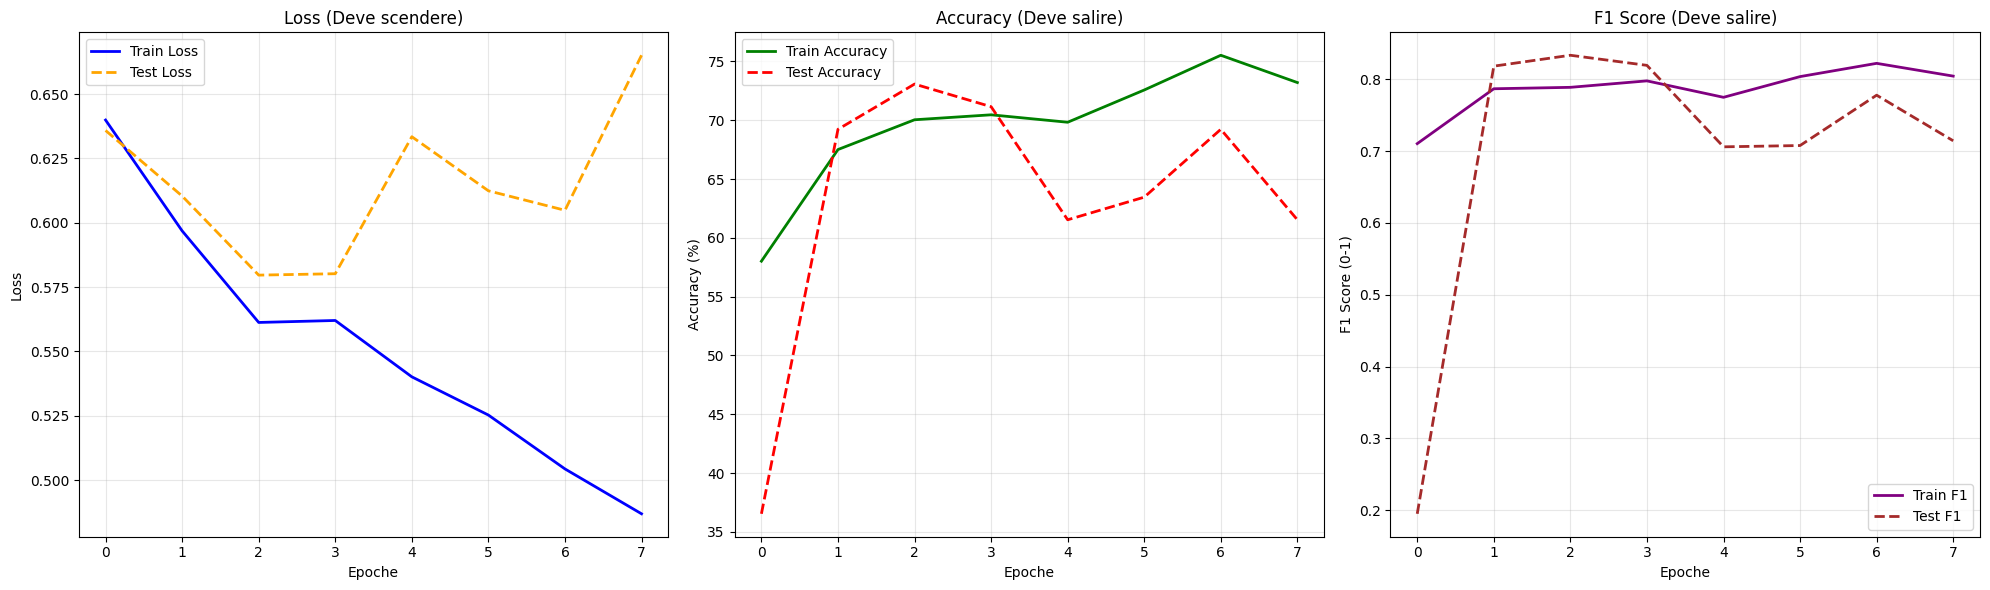

In [43]:
import matplotlib.pyplot as plt

# Creiamo una figura con 3 grafici affiancati (1 riga, 3 colonne)
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# --- Grafico 1: LOSS (Errore) ---
# Questo ci dice se il modello sta imparando (deve scendere)
axs[0].plot(train_loss_single_fold, label='Train Loss', color='blue', linewidth=2)
axs[0].plot(test_loss_single_fold, label='Test Loss', color='orange', linestyle='--', linewidth=2)
axs[0].set_title('Loss (Deve scendere)')
axs[0].set_xlabel('Epoche')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True, alpha=0.3)

# --- Grafico 2: ACCURACY ---
# Ci dice la percentuale totale di risposte corrette (deve salire)
axs[1].plot(accuracy_list_single_fold_train, label='Train Accuracy', color='green', linewidth=2)
axs[1].plot(accuracy_list_single_fold, label='Test Accuracy', color='red', linestyle='--', linewidth=2)
axs[1].set_title('Accuracy (Deve salire)')
axs[1].set_xlabel('Epoche')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].grid(True, alpha=0.3)

# --- Grafico 3: F1 SCORE ---
# Critico per dati sbilanciati o medici: media armonica tra precisione e recupero
axs[2].plot(f1_list_single_fold_train, label='Train F1', color='purple', linewidth=2)
axs[2].plot(f1_list_single_fold, label='Test F1', color='brown', linestyle='--', linewidth=2)
axs[2].set_title('F1 Score (Deve salire)')
axs[2].set_xlabel('Epoche')
axs[2].set_ylabel('F1 Score (0-1)')
axs[2].legend()
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

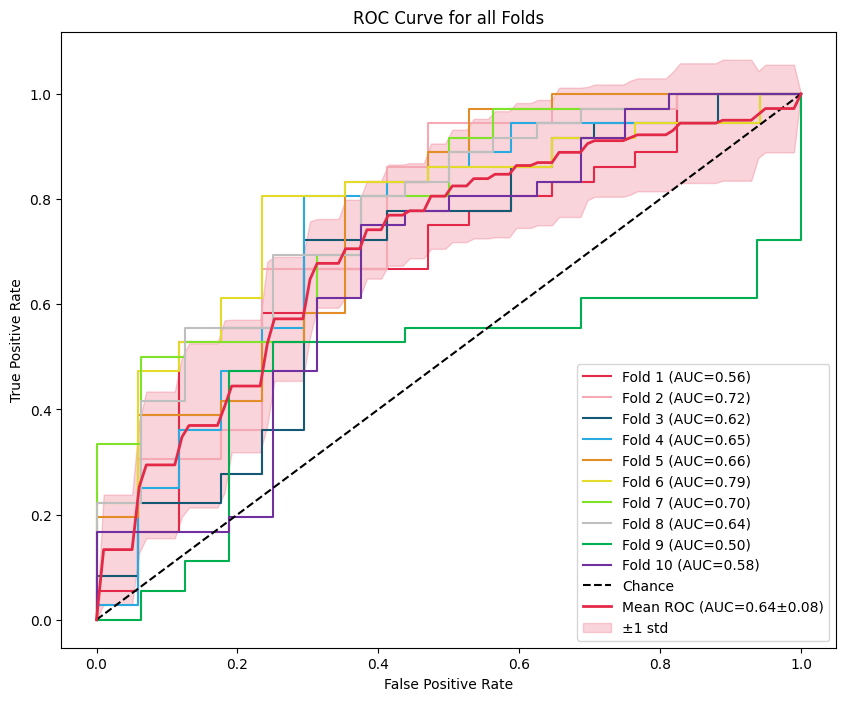

In [44]:
plt.figure(figsize=(10, 8))

# Custom color palette
colors = [
    "#E32947",  # red
    "#F4A9B5",  # pink
    "#155874",  # dark blue
    "#29ABE2",  # light blue
    "#E38D29",  # orange
    "#E3DA29",  # yellow
    "#7FE329",  # green (flashy)
    "#BFBFBF",  # grey
    "#00B050",  # green (basic)
    "#7030A0",  # purple
    "#996633",  # brown
]
# Repeat colors if more folds than colors
while len(colors) < len(fpr_list_all_folds):
    colors += colors

mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

for i in range(len(fpr_list_all_folds)):
    interp_tpr = np.interp(mean_fpr, fpr_list_all_folds[i], tpr_list_all_folds[i])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    auc_val = auc_score_list_all_folds[i] if i < len(auc_score_list_all_folds) else None
    aucs.append(auc_val)
    plt.plot(
        fpr_list_all_folds[i],
        tpr_list_all_folds[i],
        color=colors[i],
        label=f'Fold {i+1} (AUC={auc_val:.2f})'
    )

plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Chance')

# Mean and std curves
tprs = np.array(tprs)
mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(aucs)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr,
    mean_tpr,
    color="#E32947",
    label=f'Mean ROC (AUC={mean_auc:.2f}±{std_auc:.2f})',
    linewidth=2
)
plt.fill_between(
    mean_fpr,
    mean_tpr - std_tpr,
    mean_tpr + std_tpr,
    color="#E32947",
    alpha=0.2,
    label='±1 std'
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc='lower right')
plt.show()

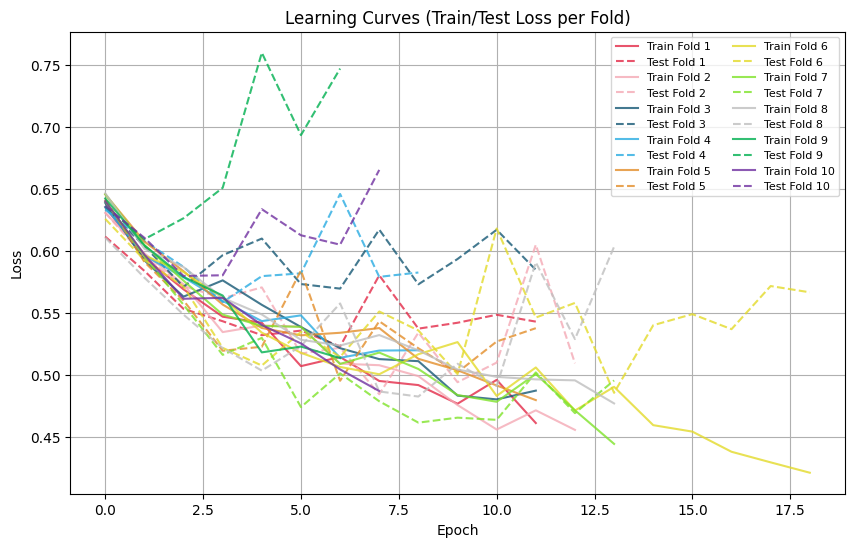

In [45]:
# Plot learning curves (train and test loss per epoch for each fold)
plt.figure(figsize=(10, 6))

for i in range(len(train_loss_all_folds)):
    plt.plot(train_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, label=f'Train Fold {i+1}')
    plt.plot(test_loss_all_folds[i], color=colors[i % len(colors)], alpha=0.8, linestyle='--', label=f'Test Fold {i+1}')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curves (Train/Test Loss per Fold)")
plt.legend(ncol=2, fontsize=8)
plt.grid(True)
plt.show()

=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===
      Accuracy  F1 Score  Sensitivity (Recall)  Specificity     AUC
mean    0.7529    0.8414                0.9500       0.3261  0.6381
std     0.0453    0.0189                0.0520       0.2486  0.0994
min     0.6923    0.8182                0.8611       0.0000  0.5000
max     0.8302    0.8732                1.0000       0.7647  0.8129


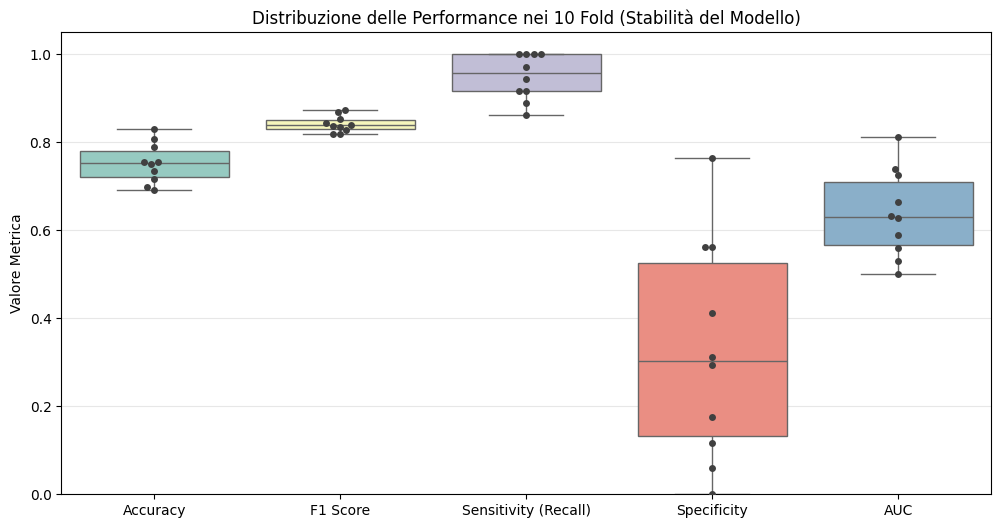

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Creazione di un DataFrame con tutti i risultati
results_data = {
    'Accuracy': np.array(accuracy_list_all_folds) / 100,  # <--- DIVISO PER 100
    'F1 Score': f1_list_all_folds,
    'Sensitivity (Recall)': sensitivity_list_all_folds,
    'Specificity': specificity_list_all_folds,
    'AUC': auc_score_list_all_folds
}

df_results = pd.DataFrame(results_data)

# 2. Calcolo delle Statistiche (Media e Deviazione Standard)
# La deviazione standard (std) ti dice quanto il modello è "instabile" tra un fold e l'altro
summary = df_results.describe().loc[['mean', 'std', 'min', 'max']]

print("=== REPORT PERFORMANCE MEDIE (10-Fold CV) ===")
print(summary.round(4))

# 3. Visualizzazione Grafica (Boxplot)
# Questo grafico è fondamentale: la linea verde è la mediana, la scatola è dove cade il 50% dei casi.
# Se la scatola è molto "alta", il modello è instabile. Se è schiacciata, è molto robusto.
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_results, palette="Set3")
sns.swarmplot(data=df_results, color=".25") # Aggiunge i punti reali per vedere la dispersione

plt.title('Distribuzione delle Performance nei 10 Fold (Stabilità del Modello)')
plt.ylabel('Valore Metrica')
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(0, 1.05) # Fissa l'asse Y tra 0 e 1 (o poco più per l'accuracy se è in %)
# Se l'accuracy è in scala 0-100, commenta la riga sopra o adattala a (0, 105)

plt.show();